Books: 

https://www.taylorfrancis.com/books/edit/10.1201/9780367631888/recommender-systems-pavan-kumar-vairachilai-sirisha-potluri-sachi-nandan-mohanty

https://beluga.sub.uni-hamburg.de/vufind/Record/1656091313?rank=1

In [22]:
import pandas as pd
import numpy as np
import random

In [23]:
df = pd.read_csv("person-skills_2022-06-27.csv",sep=";")

## Explore data

Check categories and drop any which of "obsolete" skills. 

In [24]:
df["category"].unique()

array(['Betriebssystem', 'Datenbank',
       'Programmiersprachen / Scriptsprachen', 'Entwicklung',
       'Java Frameworks', 'Umgebungen', 'JavaScript Frameworks',
       'Standards', 'Applikationsserver', 'Dienste', 'Technik/Tools',
       'Webentwicklung', 'CI/CD, Build- und Versionskontrollsysteme',
       'Produkterfahrung', 'Grafik/Design', 'Methoden und Praktiken',
       'Software Craftmanship', 'Projektmanagement / Vorgehensmodelle',
       'Sprachen', 'Einsatzfelder / Erfahrungen / Schwerpunkte',
       'Sonstige', 'Issue Management', '.NET Frameworks und Tools',
       'BPM (Business Process Modelling)', 'TYPO3', 'SAP Commerce', 'CMS',
       'Branchenerfahrung', 'UX/UI Tools ', 'PHP', 'Cloud Computing',
       'Server', 'Zertifizierung', 'Beratung', 'Modellierungswerkzeuge',
       'ERP', 'Data Warehouse / Business Intelligence', 'Agilität',
       'Tests', 'Basics', 'C++ Frameworks und Tools', 'Rolle (intern)',
       'nxp Abteilungen'], dtype=object)

In [25]:
df[df["category"] == "Rolle (intern)"]["skill"].unique()

array(['Datenschutzbeauftragter', 'Datenschutzauditor'], dtype=object)

Dropping: "Betriebssystem", "Dienste", "Einsatzfelder / Erfahrungen / Schwerpunkte", "Rolle (intern)"

In [26]:
data = df[~df["category"].isin(["Betriebssystem", "Dienste", "Einsatzfelder / Erfahrungen / Schwerpunkte", "Rolle (intern)"])]

In [27]:
data.head(20)

,person,skill,category
6,12,PostgreSQL,Datenbank
7,12,MySQL,Datenbank
8,12,LDAP,Datenbank
9,12,Microsoft Access,Datenbank
10,12,Java,Programmiersprachen / Scriptsprachen
11,12,C#,Programmiersprachen / Scriptsprachen
12,12,Cobol,Programmiersprachen / Scriptsprachen
13,12,Assembler,Programmiersprachen / Scriptsprachen
14,12,Entwurfsmuster,Entwicklung
15,12,Java EE,Java Frameworks


In [28]:
employee_dict = {}
for n in range(1,data["person"].nunique()+1):
    employee_dict[n] = data["person"].unique()[n-1]

In [29]:
# So later functions work, it makes sense to rename persons from 1 to maxno. 
# Create dictionary which matches the employee
persons = np.arange(1,len(data["person"].unique())+1)
skills = sorted(data["skill"].unique())

In [31]:
skills_per_person = []
for person in data["person"].unique(): 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == person]["skill"].unique():
            skillset.append(1)
        else:
            skillset.append(0)
    skills_per_person.append(skillset)


In [32]:
matrix = pd.DataFrame(index=persons,columns=skills,data=skills_per_person)

In [33]:
matrix

,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,ARIS,ARIS ITArchitect,ASP Generalist,ASP.NET,...,prototype,pycharm,ramda.js,ranorex,script.aculo.us,varnish,visual paradigm,vs code,xHTML,xtCommerce
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
381,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
382,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
383,0,1,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Employee-employee approach

Similarity between employees: due to dichotomous nature of data, Jaccard similarity is used for computing the similarity between employees. 

In [34]:
def jaccard_binary(x,y):
    """A function for finding the similarity between two binary vectors"""
    intersection = np.logical_and(x, y)
    union = np.logical_or(x, y)
    similarity = intersection.sum() / float(union.sum())
    return similarity

In [35]:
def compute_jaccard_sim(data,employee):
    sim = pd.DataFrame(index=[employee])
    employee_data = data.loc[employee]
    sim_data = data.drop(employee,axis=0)
    for emp in sim_data.index:
        new_sim = pd.DataFrame(index=[employee],columns=[emp],data=jaccard_binary(employee_data,sim_data.loc[emp]))
        sim = pd.concat([sim,new_sim],axis=1)
    return sim       

In [36]:
def compute_n_nearest_neighbors(data,employee,n):
    neighbors = pd.DataFrame(index=[employee])
    similarities = compute_jaccard_sim(data,employee)
    for i in range(0,n):
        nearest_neighbor = similarities[similarities.idxmax(axis=1)]
        neighbors = pd.concat([neighbors,nearest_neighbor],axis=1)
        similarities.drop(nearest_neighbor,axis=1,inplace=True)
    return neighbors.columns.to_list()

In [37]:
def predict_skills_for_employee(data,employee,n_neighbors):
    neighbors = compute_n_nearest_neighbors(data,employee,n_neighbors)
    values_of_employee = data.loc[employee].to_numpy()
    neighbors_matrix = data.loc[neighbors].to_numpy()
    predicted_values = np.array([])
    for i in range(0,len(values_of_employee)):
        if values_of_employee[i] == 0: 
            predicted_values = np.append(predicted_values,
                                            # weighted averahe might be more accurate
                                            np.mean(neighbors_matrix[:,i]))
        else: 
            predicted_values = np.append(predicted_values,values_of_employee[i])
    return predicted_values

In [38]:
def predict_skills_for_matrix(data,n_neighbors): 
    # create emppy array of length according to columns (in order for later vstack to work)
    return_data = np.zeros(len(data.columns))
    for i in data.index: 
        single_predicition = predict_skills_for_employee(data,i,n_neighbors)
        return_data = np.vstack([return_data,single_predicition])
    # delete first entry (zeros) from return data
    return_data = return_data[1:len(return_data)]
    return pd.DataFrame(index=data.index,columns=data.columns,data=return_data)

In [39]:
predict_skills_for_matrix(matrix,10)

,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,ARIS,ARIS ITArchitect,ASP Generalist,ASP.NET,...,prototype,pycharm,ramda.js,ranorex,script.aculo.us,varnish,visual paradigm,vs code,xHTML,xtCommerce
1,0.0,0.0,0.4,0.1,0.0,0.0,0.0,0.0,0.1,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0
2,0.2,0.2,1.0,0.2,0.0,1.0,0.0,0.0,0.3,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.1,0.3,0.0
3,0.1,0.0,0.1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.1,0.2,0.0,0.0,0.0,0.0,0.0,0.1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.5,0.0
5,0.1,0.0,0.0,0.1,0.0,0.0,0.1,0.1,0.1,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.3,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.0,0.0,0.2,0.0,0.0,0.0,0.0,0.0,0.1,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,0.0,0.0,0.0,0.1,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.1,0.0,0.1,0.0,0.2,0.0
382,0.1,0.1,0.1,0.0,0.0,0.1,0.0,0.0,0.0,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.1,1.0,1.0,0.0,0.0,0.2,0.0,0.0,0.1,0.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.2,0.0


Create matrix with values between 1 and 5 for recommender trials

Values between 1 and 5 should not be arbitrary. As weight for their score, the frequency of the underlying category for each skill will be taken into account. For instance, if employee 12 has four skills in the category programming language and one skill in data banks, each programming skill will be evaluated with a respectivley high score. 

In [40]:
skills_to_category = pd.read_csv("mitarbeiterportal-skills_2022-06-21.csv",sep=";",header=None)
category_dict = dict(zip(skills_to_category[0],skills_to_category[1]))

In [41]:
def scaler_1_5(x,old_max,old_min):
    OldRange = (old_max - old_min)  
    if (OldRange == 0):
        return 1
    else:
        NewRange = (5 - 1)  
        return round((((x - 1) * NewRange) / OldRange) + 1)

In [42]:
# create dataframe for each employee and their category count
categories = data["category"].unique()
category_per_employee = pd.DataFrame(index=categories)
for p in persons:
    p_skills = data[data["person"] == employee_dict[p]]
    # count categories for each employee
    category_count = p_skills["category"].value_counts()
    category_count = category_count.apply(lambda x:scaler_1_5(x,category_count.max(),category_count.min()))
    skill_values = np.array([])
    # add count for each category to an array and 0 if category wasn't found (and therefore is not part of resptive employee's skillset)
    for cat in categories:
        try:
            skill_values = np.append(skill_values,category_count[cat])
        except KeyError:
            skill_values = np.append(skill_values,0)
    # add employee data to dataframe
    p_skills_df = pd.DataFrame(index=categories,columns=[p],data=skill_values)
    category_per_employee = pd.concat([category_per_employee,p_skills_df],axis=1)

In [45]:
skills_per_person_weighted = []
for p in persons: 
    skillset = []
    for skill in skills:
        if skill in data[data["person"] == employee_dict[p]]["skill"].unique():
            skillset.append(category_per_employee[p][category_dict[skill]])
        else:
            skillset.append(0)    
    skills_per_person_weighted.append(skillset)

KeyError: 'NativeScript '

In [ ]:
matrix_mod = pd.DataFrame(index=persons,columns=skills,data=skills_per_person_weighted)
matrix_mod

,.NET Compact Framework,.NET Core,.NET Framework,3D-Modellierung,ABAP,ADO.NET,ARIS,ARIS ITArchitect,ASP Generalist,ASP.NET,...,prototype,pycharm,ramda.js,ranorex,script.aculo.us,varnish,visual paradigm,vs code,xHTML,xtCommerce
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,5.0,0.0,0.0,5.0,0.0,0.0,0.0,5.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
380,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
381,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
382,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
383,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


BRISMF

[Singluar Value Decomposition (SVD)](https://analyticsindiamag.com/singular-value-decomposition-svd-application-recommender-system/)

In [ ]:
# skills_array = np.array(skills_per_person_weighted)

Normalize matrix

In [ ]:
# normalised_mat = skills_array - np.asarray([np.mean(skills_array, 1)]).T

Compute SVD

In [ ]:
# A = normalised_mat.T / np.sqrt(skills_array.shape[0] - 1)
# U, S, V = np.linalg.svd(A)

In [ ]:
# def top_cosine_similarity(data, employee_id, top_n=10):
#     index = employee_id - 1 # Employee id starts from 1 in the dataset
#     employee_row = data[index, :]
#     magnitude = np.sqrt(np.einsum('ij, ij -> i', data, data))
#     similarity = np.dot(employee_row, data.T) / (magnitude[index] * magnitude)
#     sort_indexes = np.argsort(-similarity)
#     return sort_indexes[:top_n]

In [ ]:
# # Function to print top N similar movies
# def print_similar_movies(data, employee, top_indexes):
#     print('Recommendations for {0}: \n'.format(
#     data[data.index == employee].title.values[0]))
#     for id in top_indexes + 1:
#         print(data[data[] == id].title.values[0])

In [ ]:
# #k-principal components to represent movies, movie_id to find recommendations, top_n print n results        
# k = 50
# movie_id = 10 # (getting an id from movies.dat)
# top_n = 10
# sliced = V.T[:, :k] # representative data
# indexes = top_cosine_similarity(sliced, movie_id, top_n)

In [ ]:
# #Printing the top N similar movies
# print_similar_movies(movie_data, movie_id, indexes)

https://www.kaggle.com/code/ibtesama/getting-started-with-a-movie-recommendation-system

In [ ]:
import surprise

# Descriptive Analysis

In [138]:
df_value_counts = df.skill.value_counts()
df_value_counts = df_value_counts.to_frame().rename(columns = {"skill" : "frequence"}).reset_index(names = "skill")
df_value_counts

,skill,frequence
0,Englisch,315
1,MySQL,282
2,SCRUM,276
3,GIT,267
4,HTML,266
...,...,...
732,Final Cut,1
733,Datadog,1
734,Pulumi,1
735,Qlik 12 Certified Data Architekt,1


In [149]:
frequence_percent = df.skill.value_counts(normalize= True).round(4).to_list()
df_value_counts["frequence_percent"] = frequence_percent
df_value_counts

,skill,frequence,frequence_percent
0,Englisch,315,0.0128
1,MySQL,282,0.0115
2,SCRUM,276,0.0112
3,GIT,267,0.0109
4,HTML,266,0.0108
...,...,...,...
732,Final Cut,1,0.0000
733,Datadog,1,0.0000
734,Pulumi,1,0.0000
735,Qlik 12 Certified Data Architekt,1,0.0000


In [152]:
df_value_counts["freuquence_percent_cum"] = df_value_counts['frequence_percent'].cumsum()
df_value_counts

#Note: we do not reach 100%, because we rounded the percentage

,skill,frequence,frequence_percent,freuquence_percent_cum
0,Englisch,315,0.0128,0.0128
1,MySQL,282,0.0115,0.0243
2,SCRUM,276,0.0112,0.0355
3,GIT,267,0.0109,0.0464
4,HTML,266,0.0108,0.0572
...,...,...,...,...
732,Final Cut,1,0.0000,0.9976
733,Datadog,1,0.0000,0.9976
734,Pulumi,1,0.0000,0.9976
735,Qlik 12 Certified Data Architekt,1,0.0000,0.9976


In [181]:
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

In [173]:
####################
# ABC-Analysis
####################
from pandas import concat


marker_75_per = df_value_counts.loc[df_value_counts['freuquence_percent_cum'] >= 0.75].head(1)
marker_85_per = df_value_counts.loc[df_value_counts['freuquence_percent_cum'] >= 0.85].head(1)
marker_95_per = df_value_counts.loc[df_value_counts['freuquence_percent_cum'] >= 0.95].head(1)

df_markers = pd.concat([marker_75_per,marker_85_per,marker_95_per])
df_markers

,skill,frequence,frequence_percent,freuquence_percent_cum
173,Velocity,40,0.0016,0.7513
255,Markdown,23,0.0009,0.8509
421,gradle,9,0.0004,0.9502


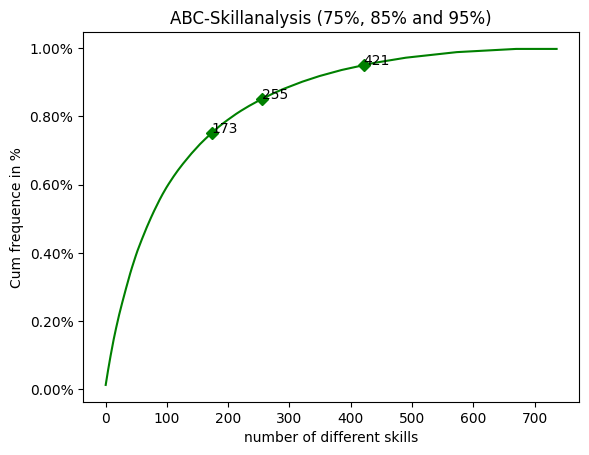

In [199]:
markers_on = df_markers.index.to_list()
markers_percentage = df_markers.freuquence_percent_cum.to_list()
fig, ax = plt.subplots()
plt.plot(df_value_counts.index, df_value_counts.freuquence_percent_cum,'-gD', markevery= markers_on)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
for i,txt in enumerate(markers_on):
    plt.annotate(txt, (markers_on[i], markers_percentage[i]))

plt.xlabel("number of different skills")
plt.ylabel("Cum frequence in %")
plt.title("ABC-Skillanalysis (75%, 85% and 95%)")
plt.show()


#Notiz: Die ersten 173 Skills werden von 75% aller Mitarbeiter beherrscht...

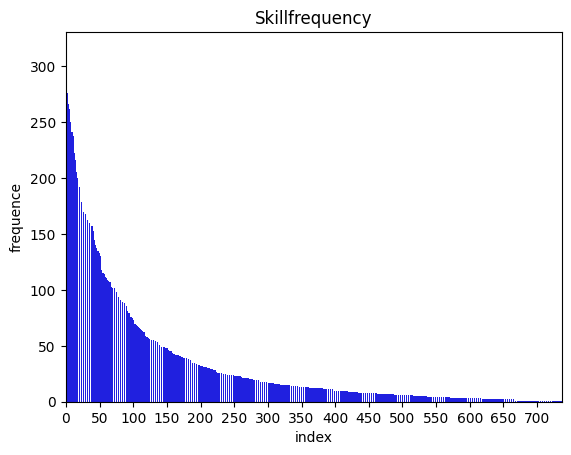

In [137]:
########################
# Plot of the skillfrequency in descending order
########################
fig, ax = plt.subplots()
sns.barplot(data = df_value_counts, x= df_value_counts.index, y = df_value_counts.frequence,color = "blue")
plt.xticks(np.arange(0,750,50))
plt.xlabel("index")
plt.title("Skillfrequency")
plt.show()

#Notiz: Unterbrechungen (weißen Streifen) noch korrigieren

In [308]:
########################
# Categories
########################
category_count = df.groupby(['category'])["skill"].count().sort_values(ascending= False).to_frame().rename(columns = {"skill" : "number_of_skills_within"}).reset_index()  
category_count

,category,number_of_skills_within
0,Webentwicklung,2251
1,Java Frameworks,1828
2,Betriebssystem,1780
3,Einsatzfelder / Erfahrungen / Schwerpunkte,1618
4,Programmiersprachen / Scriptsprachen,1615
5,Datenbank,1468
6,Methoden und Praktiken,1372
7,"CI/CD, Build- und Versionskontrollsysteme",1334
8,Projektmanagement / Vorgehensmodelle,905
9,Umgebungen,851


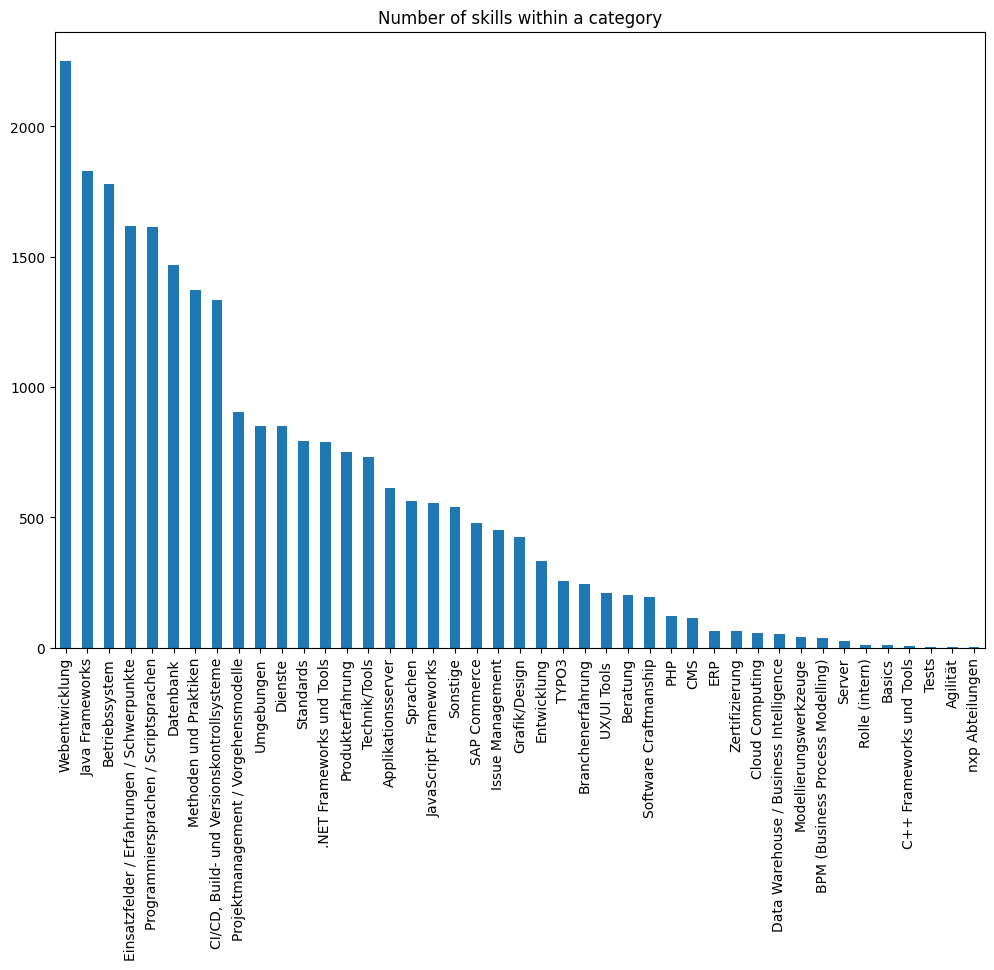

In [309]:
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = category_count.number_of_skills_within.plot(kind="bar")
ax.set_xticklabels(category_count.category)
ax.set_title("Number of skills within a category")
plt.show()

In [334]:
##################
# Distribution of Skills within a category
##################
df_groupby_category_skills = df.groupby(["category", "skill"])["skill"].count().to_frame().rename(columns={"skill": "frequence"}).reset_index()
df_groupby_category_skills.head(30)

,category,skill,frequence
0,.NET Frameworks und Tools,.NET Compact Framework,28
1,.NET Frameworks und Tools,.NET Core,10
2,.NET Frameworks und Tools,.NET Framework,87
3,.NET Frameworks und Tools,ADO.NET,23
4,.NET Frameworks und Tools,ASP Generalist,29
5,.NET Frameworks und Tools,ASP.NET,62
6,.NET Frameworks und Tools,ASP.NET MVC-Framework,50
7,.NET Frameworks und Tools,ASP.NET WebAPI,48
8,.NET Frameworks und Tools,BizTalk,6
9,.NET Frameworks und Tools,DevExpress,20


In [323]:
categories = df_groupby_category_skills.category.unique().tolist()
categories

['.NET Frameworks und Tools',
 'Agilität',
 'Applikationsserver',
 'BPM (Business Process Modelling)',
 'Basics',
 'Beratung',
 'Betriebssystem',
 'Branchenerfahrung',
 'C++ Frameworks und Tools',
 'CI/CD, Build- und Versionskontrollsysteme',
 'CMS',
 'Cloud Computing',
 'Data Warehouse / Business Intelligence',
 'Datenbank',
 'Dienste',
 'ERP',
 'Einsatzfelder / Erfahrungen / Schwerpunkte',
 'Entwicklung',
 'Grafik/Design',
 'Issue Management',
 'Java Frameworks',
 'JavaScript Frameworks',
 'Methoden und Praktiken',
 'Modellierungswerkzeuge',
 'PHP',
 'Produkterfahrung',
 'Programmiersprachen / Scriptsprachen',
 'Projektmanagement / Vorgehensmodelle',
 'Rolle (intern)',
 'SAP Commerce',
 'Server',
 'Software Craftmanship',
 'Sonstige',
 'Sprachen',
 'Standards',
 'TYPO3',
 'Technik/Tools',
 'Tests',
 'UX/UI Tools ',
 'Umgebungen',
 'Webentwicklung',
 'Zertifizierung',
 'nxp Abteilungen']

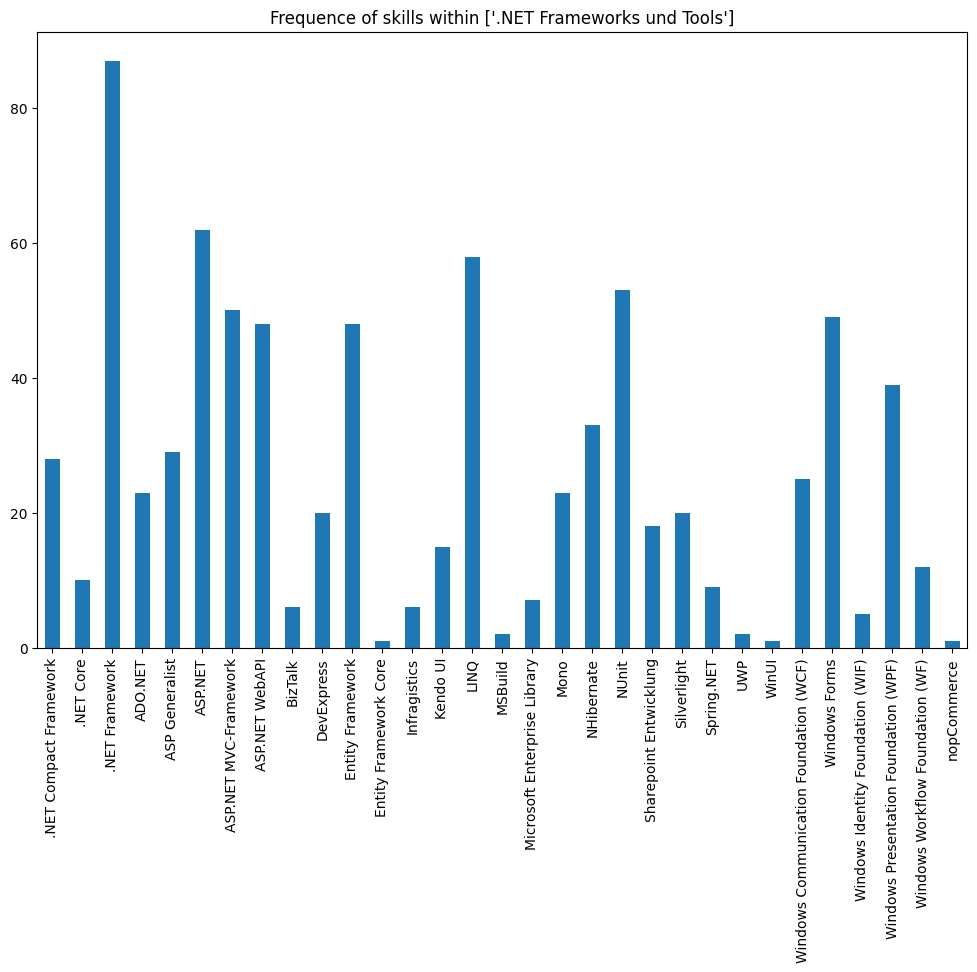

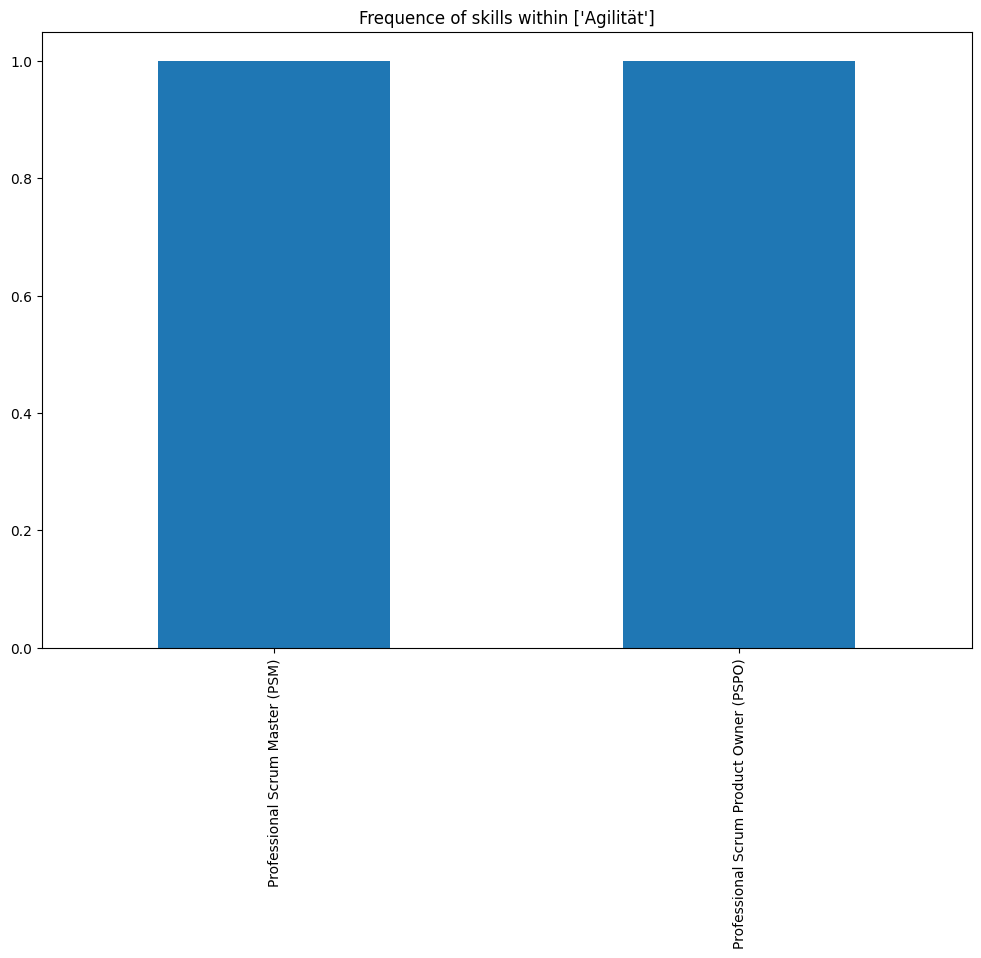

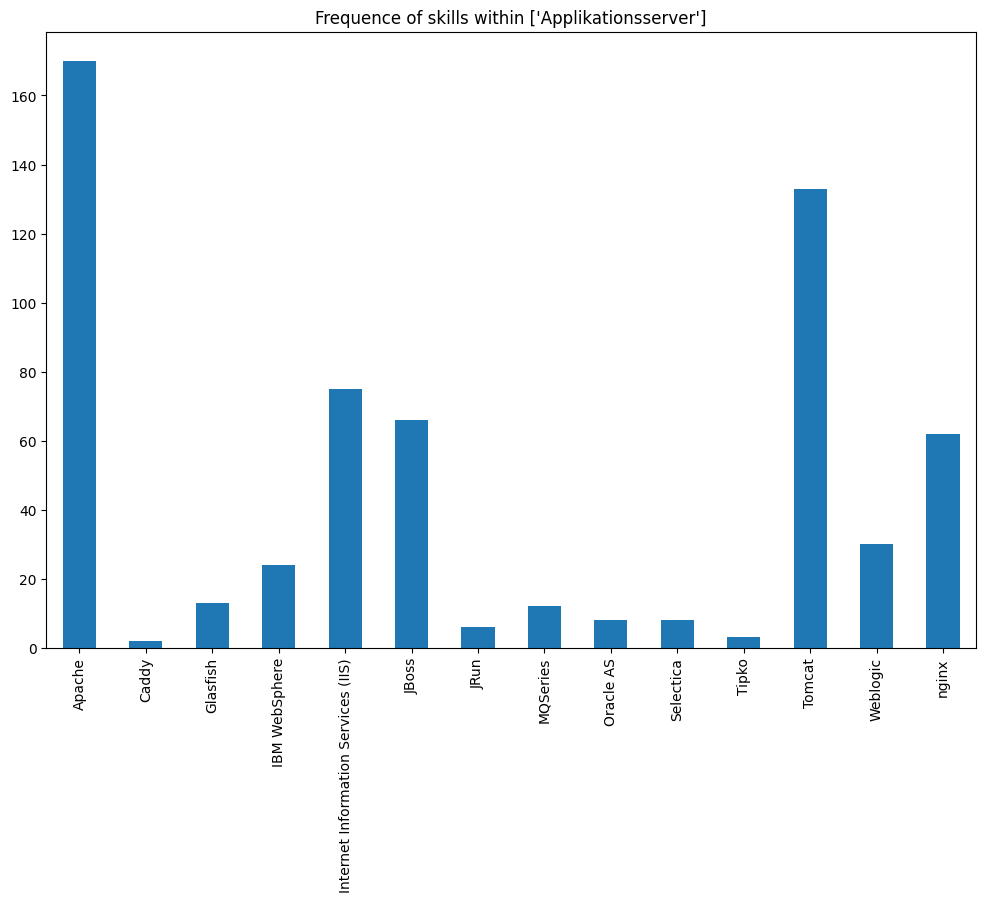

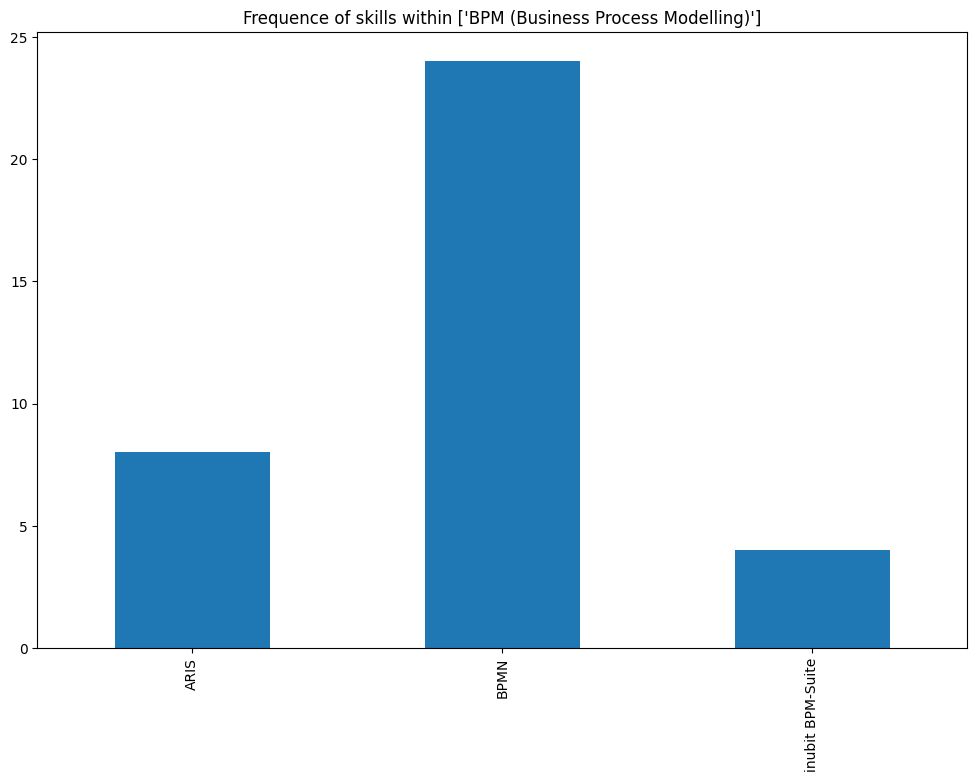

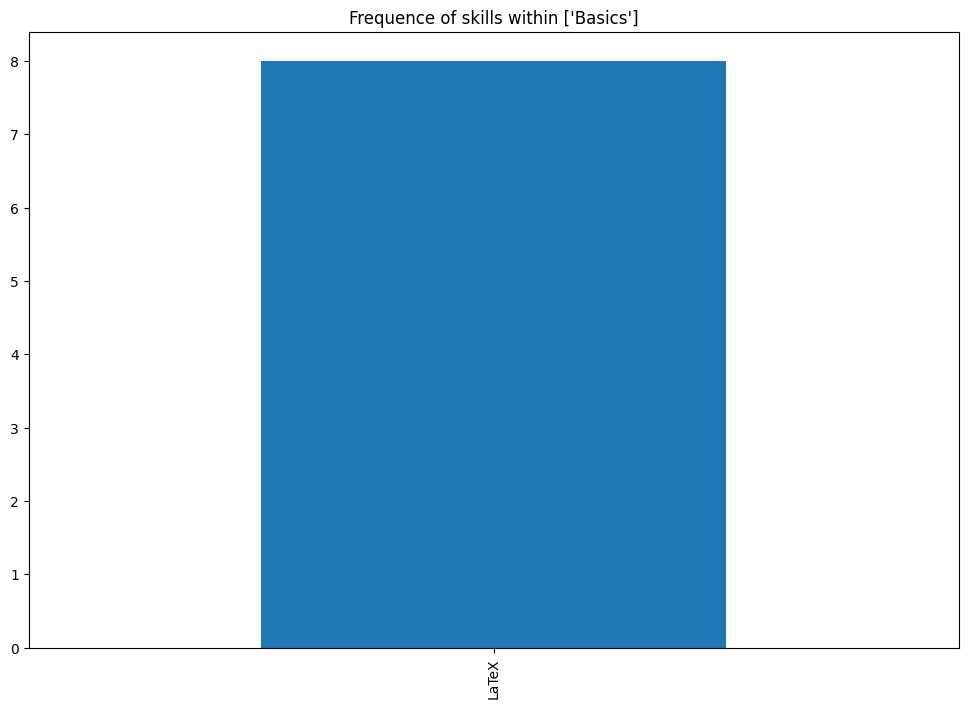

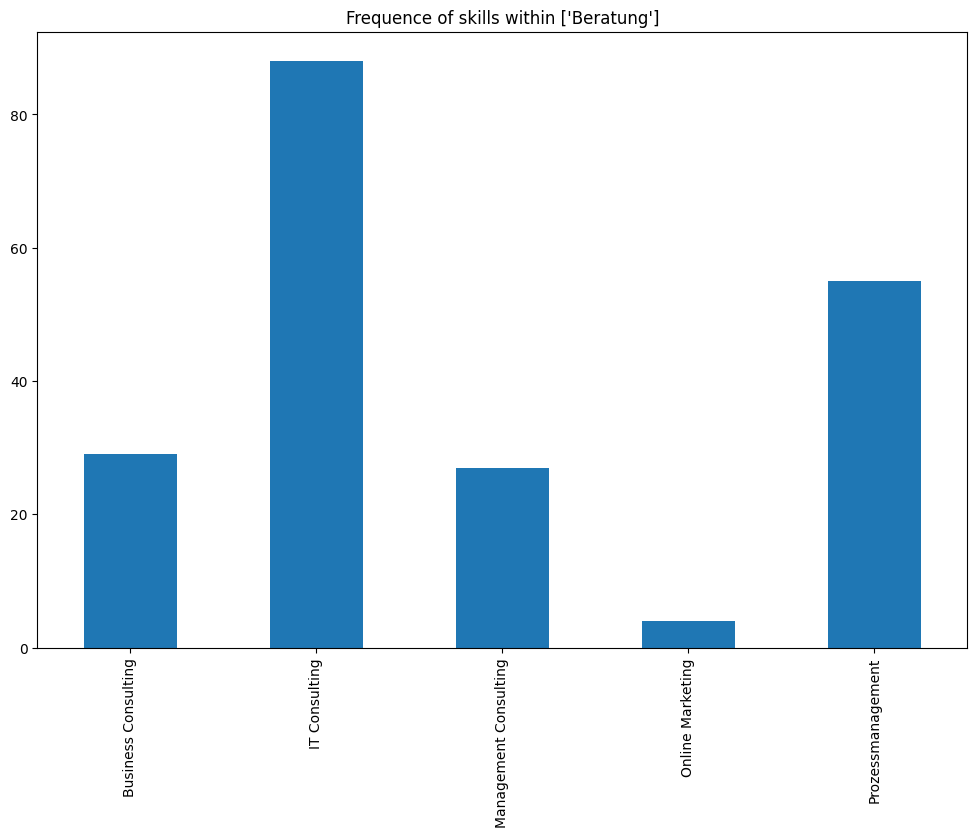

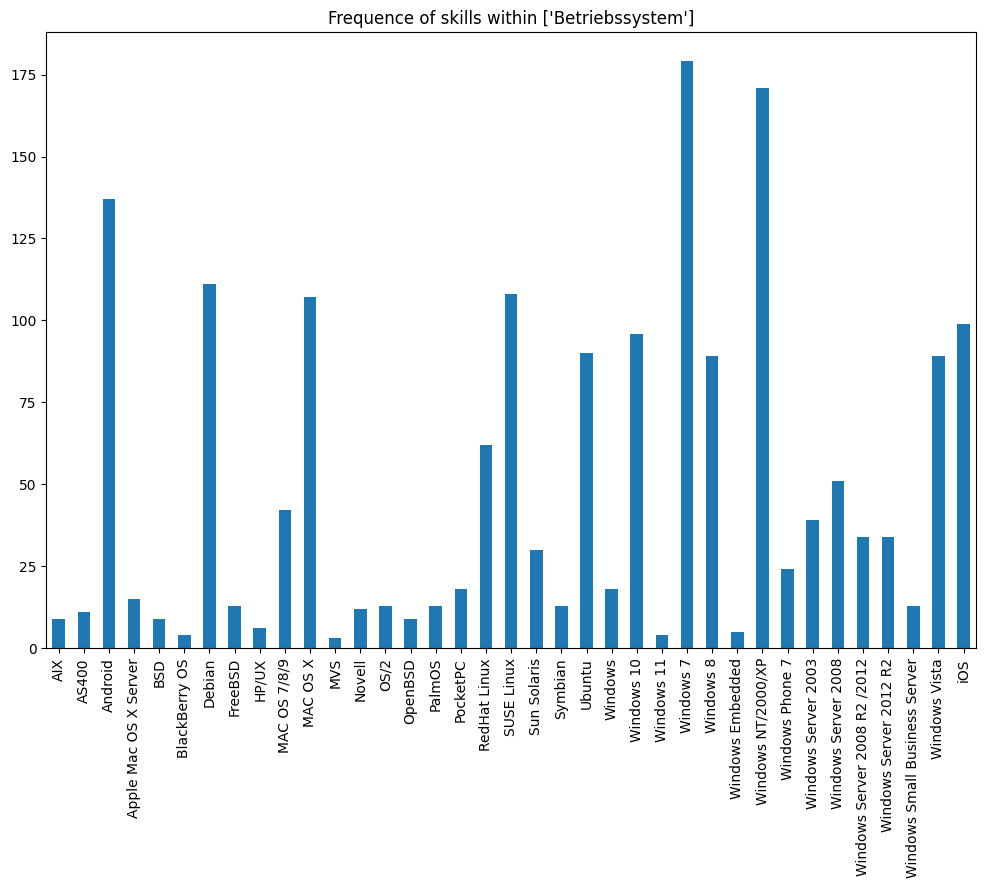

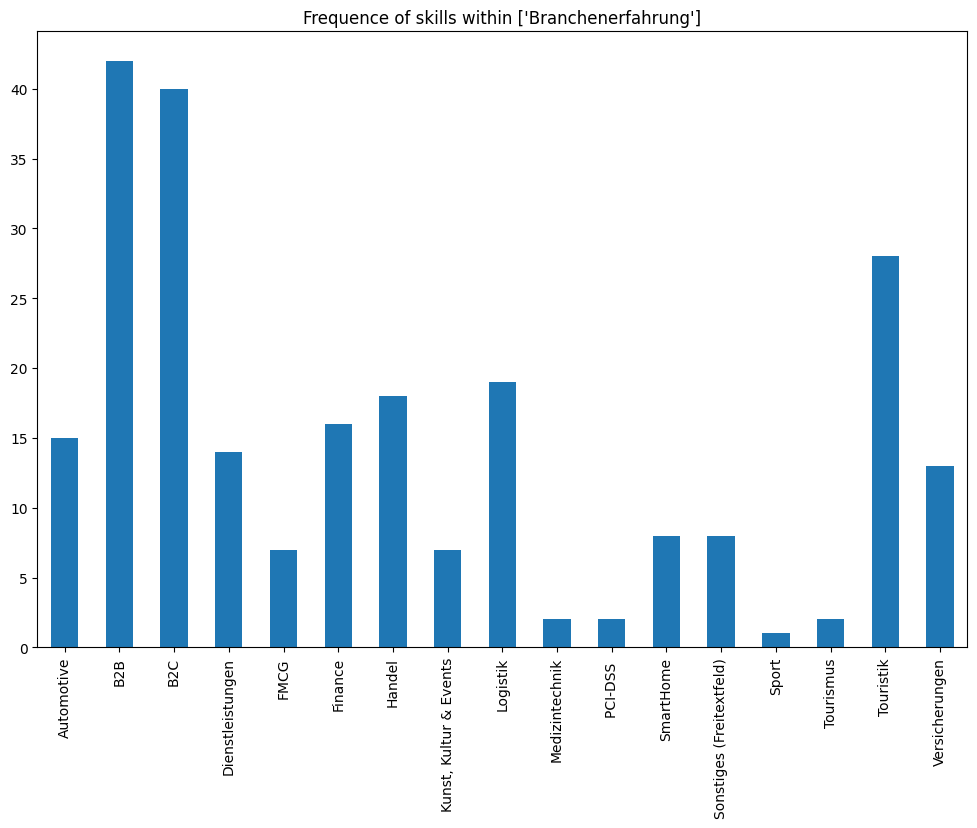

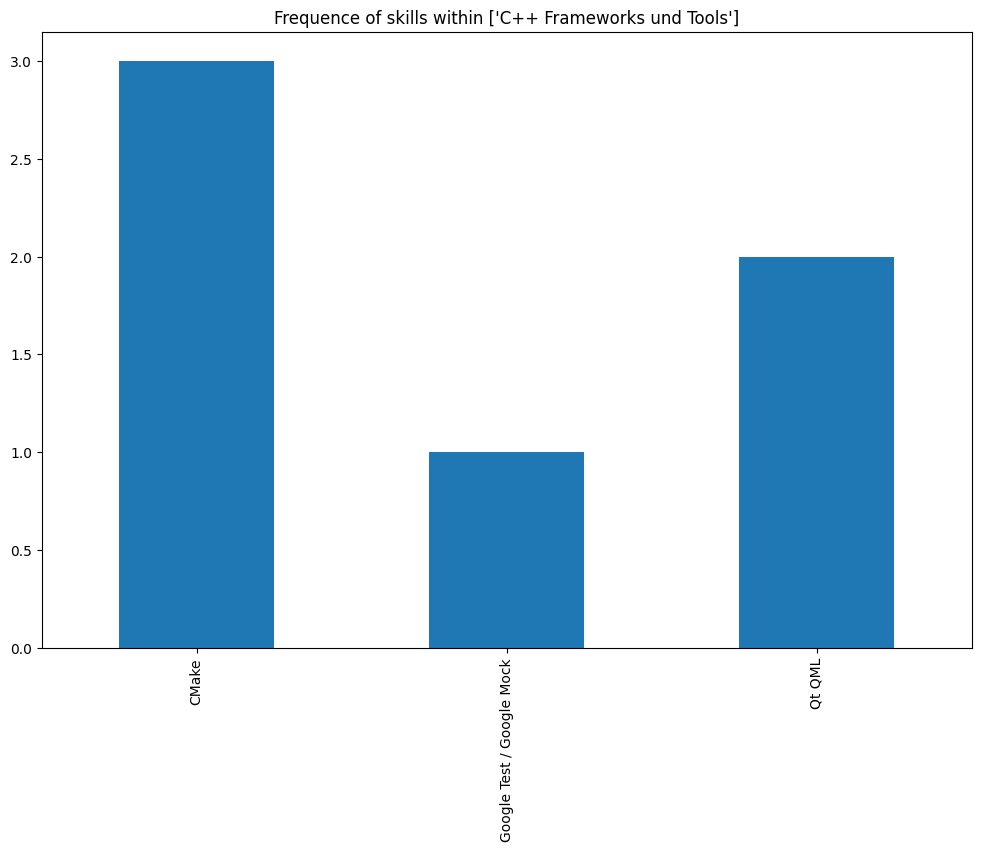

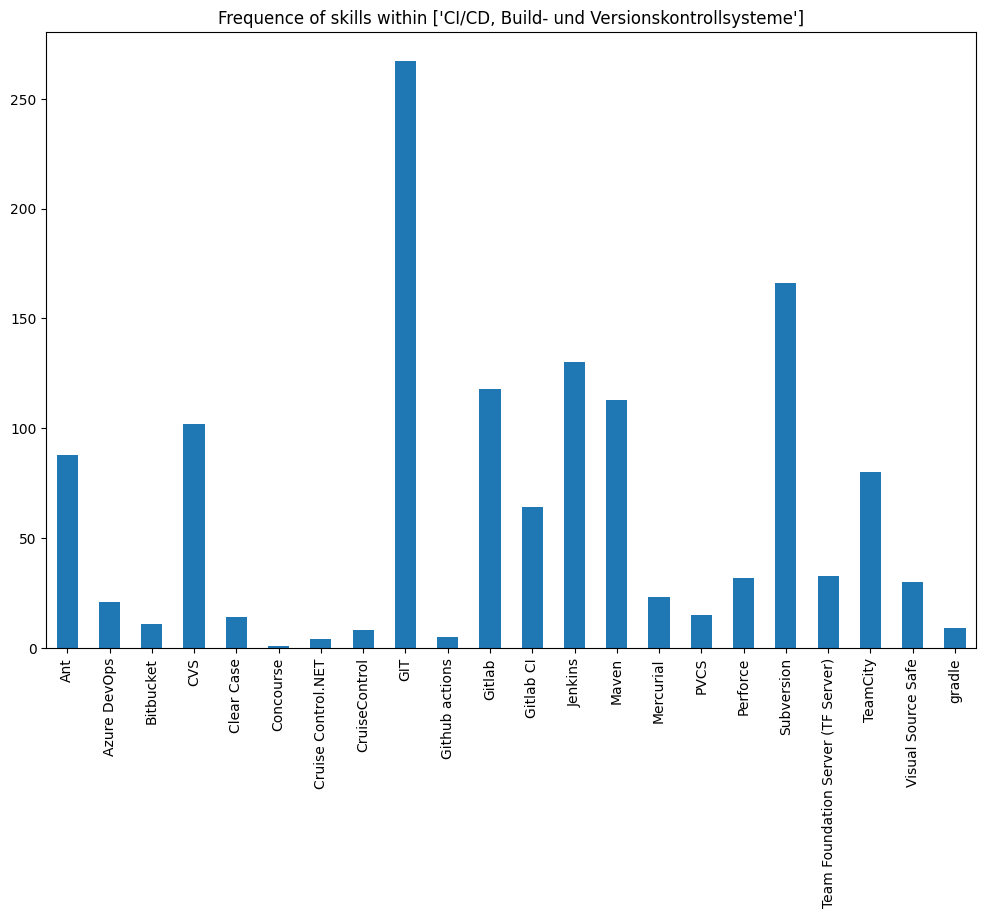

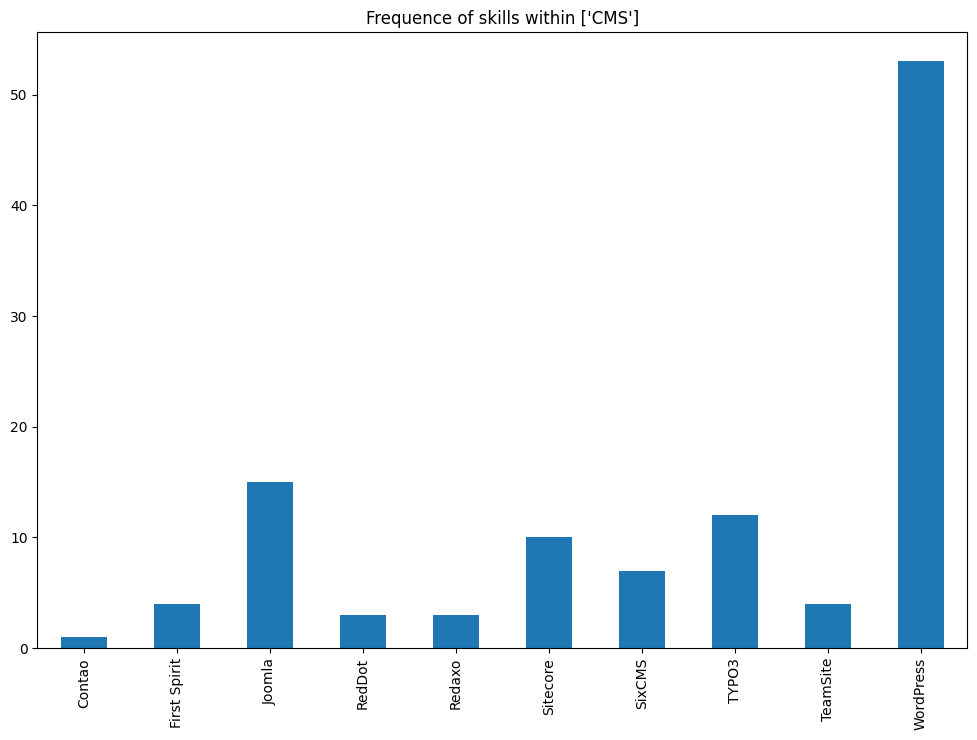

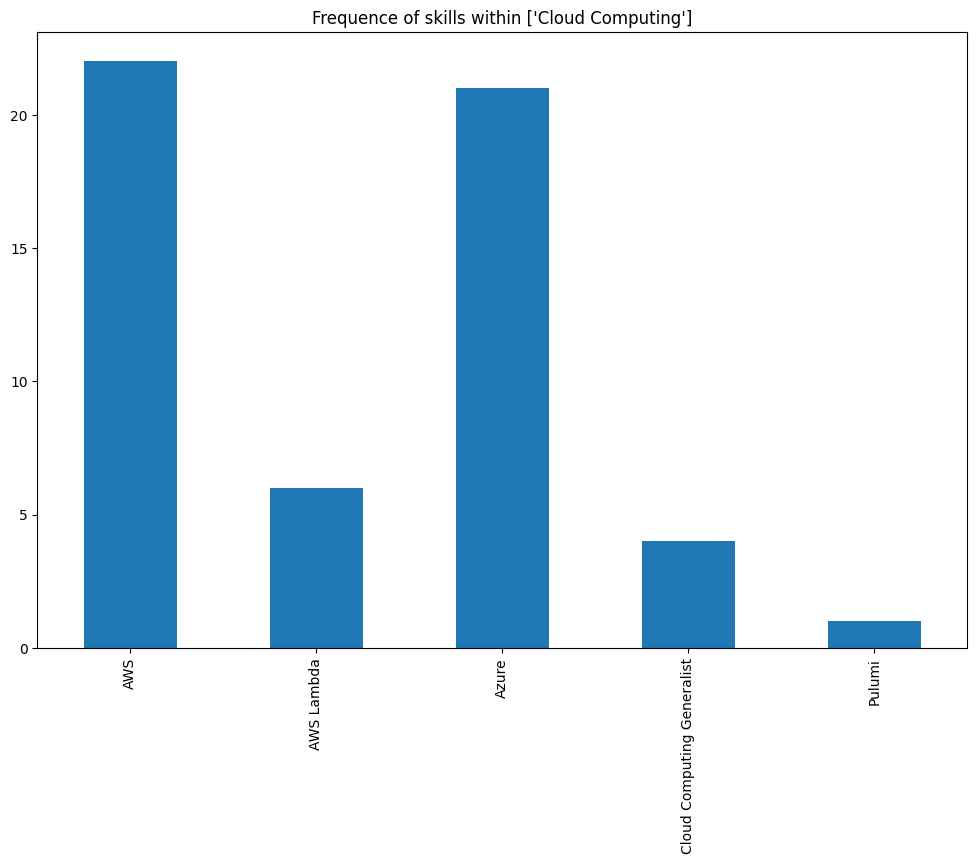

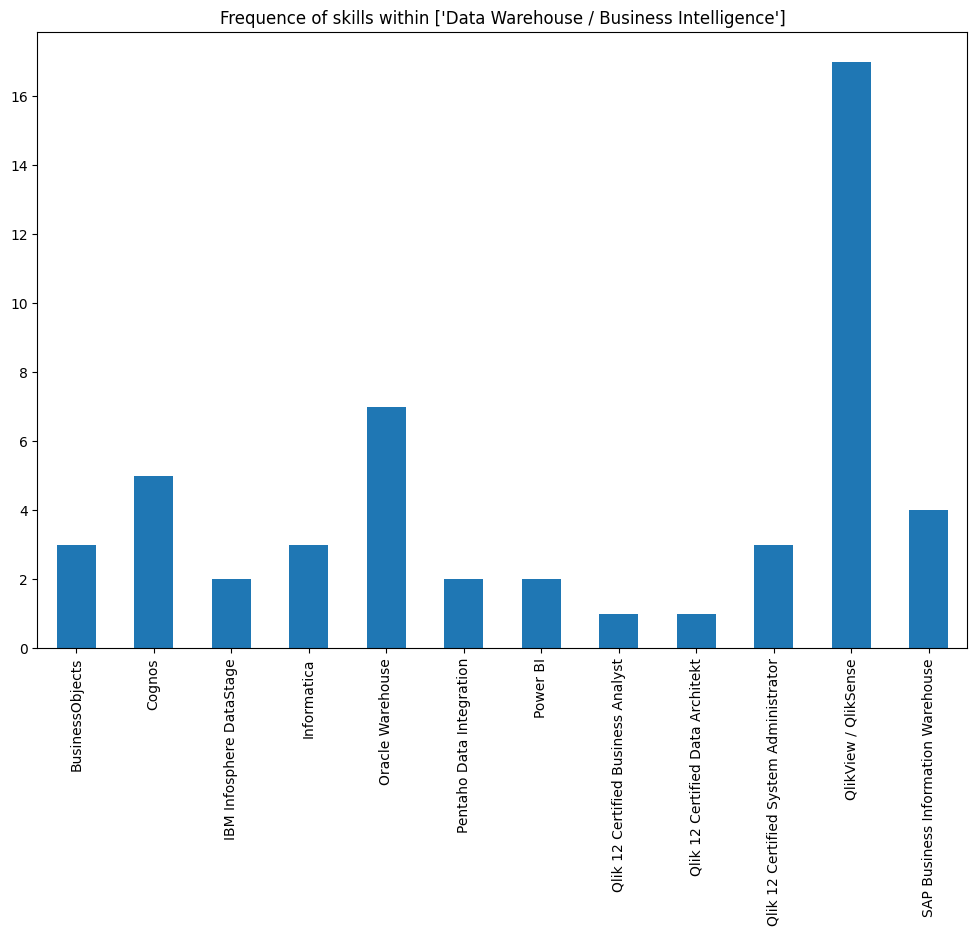

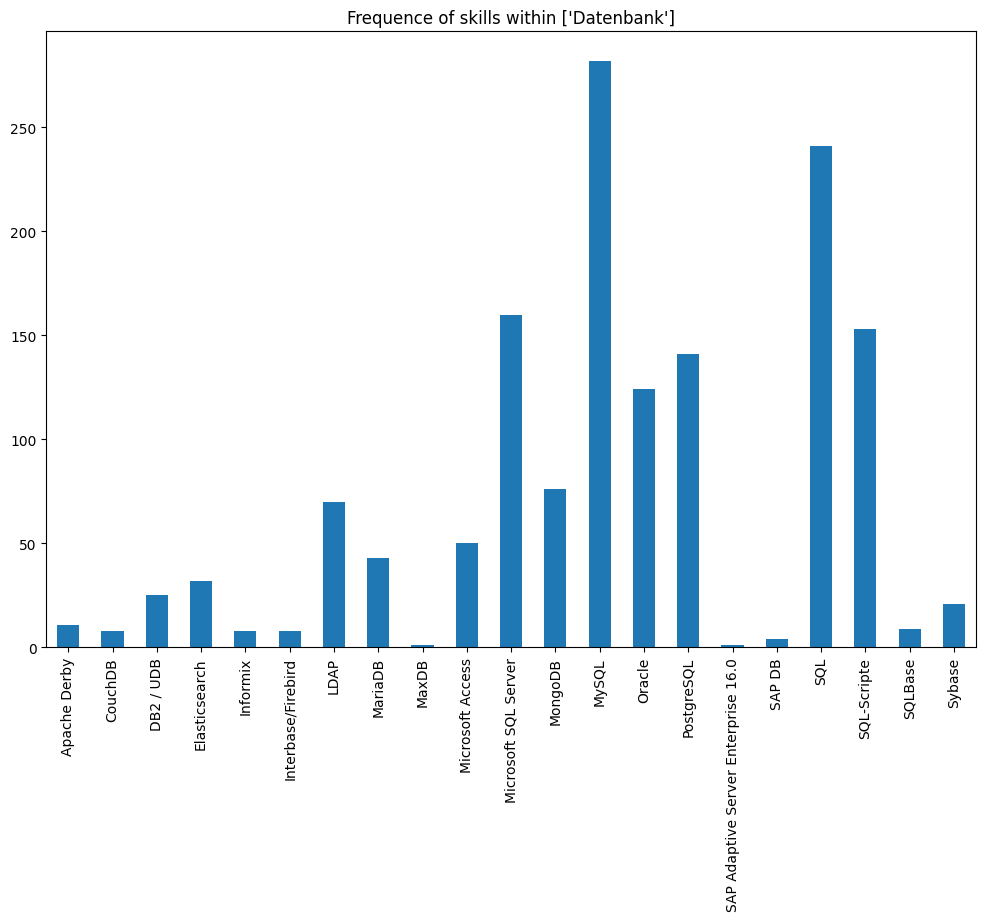

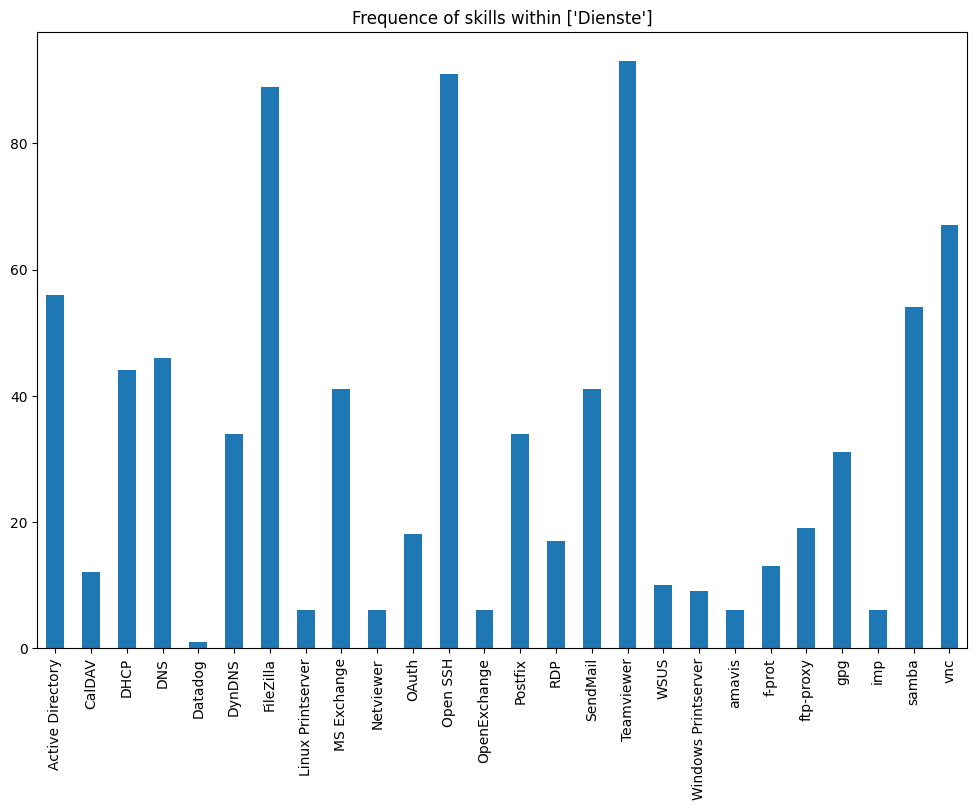

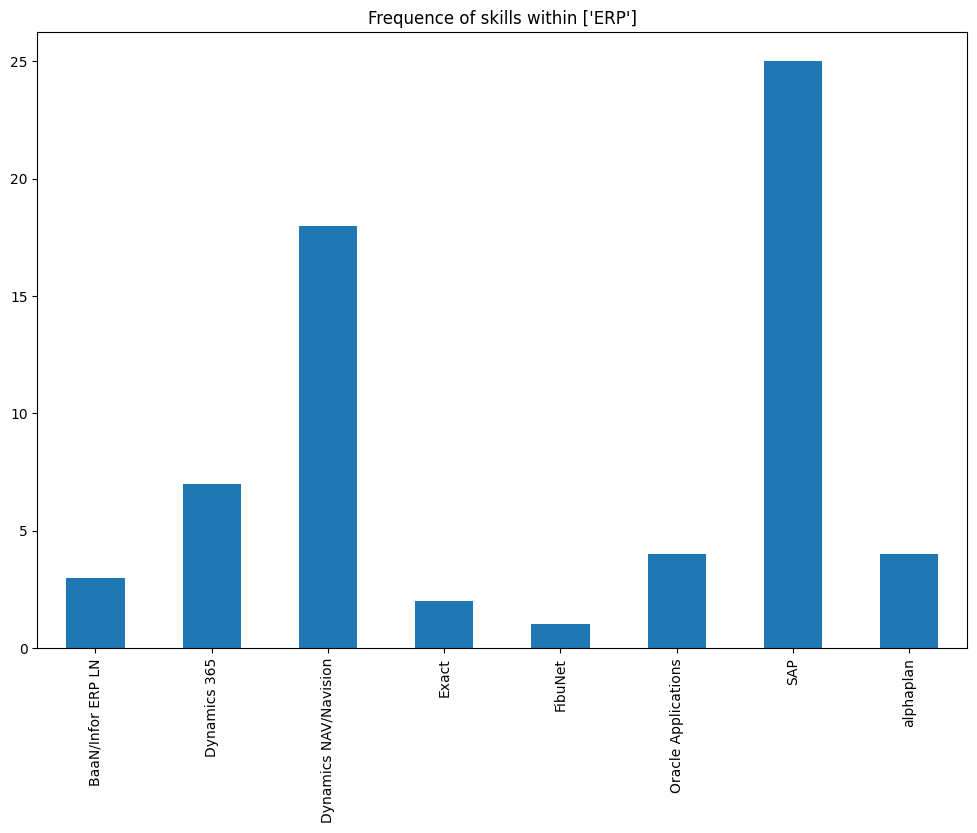

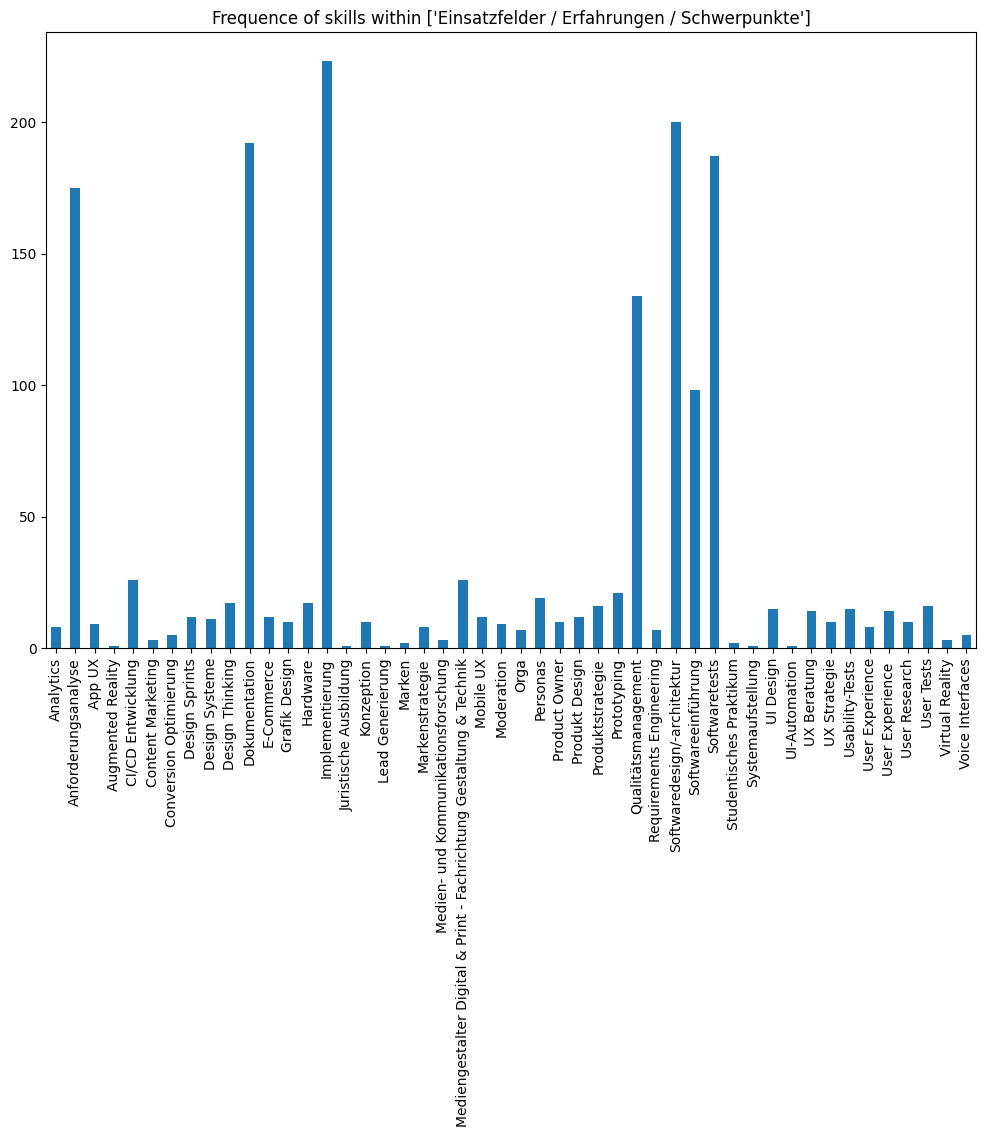

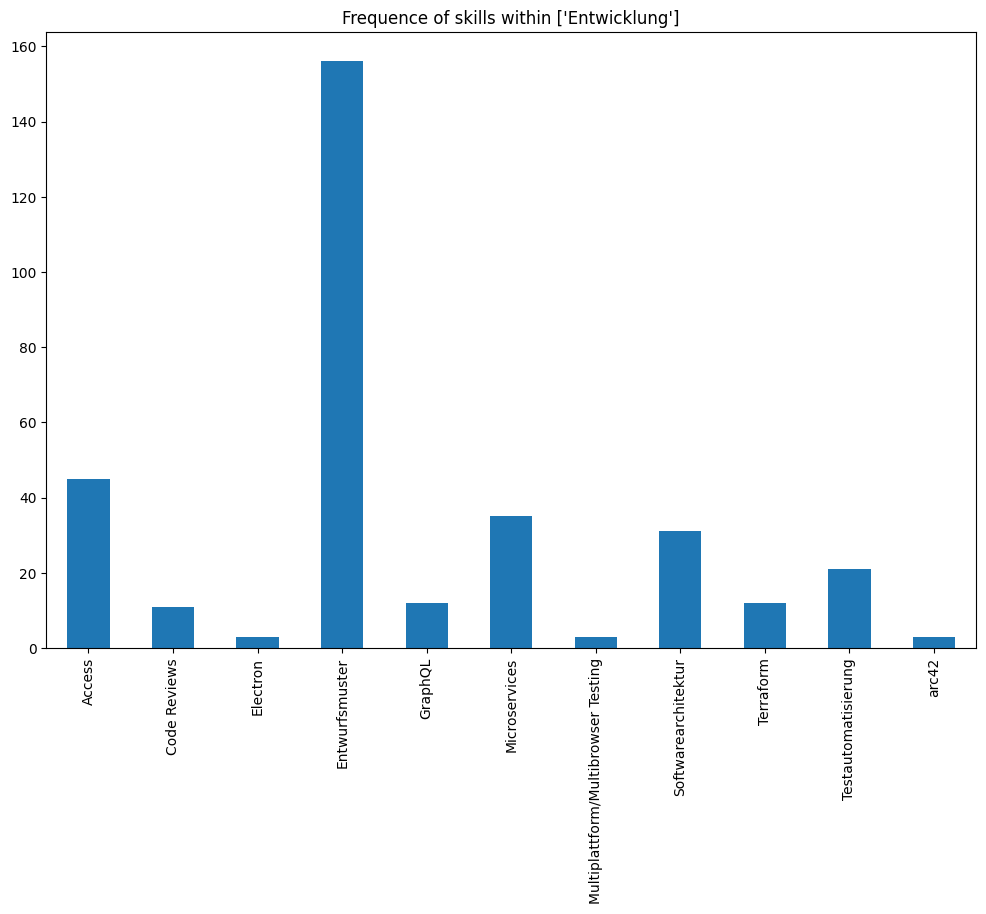

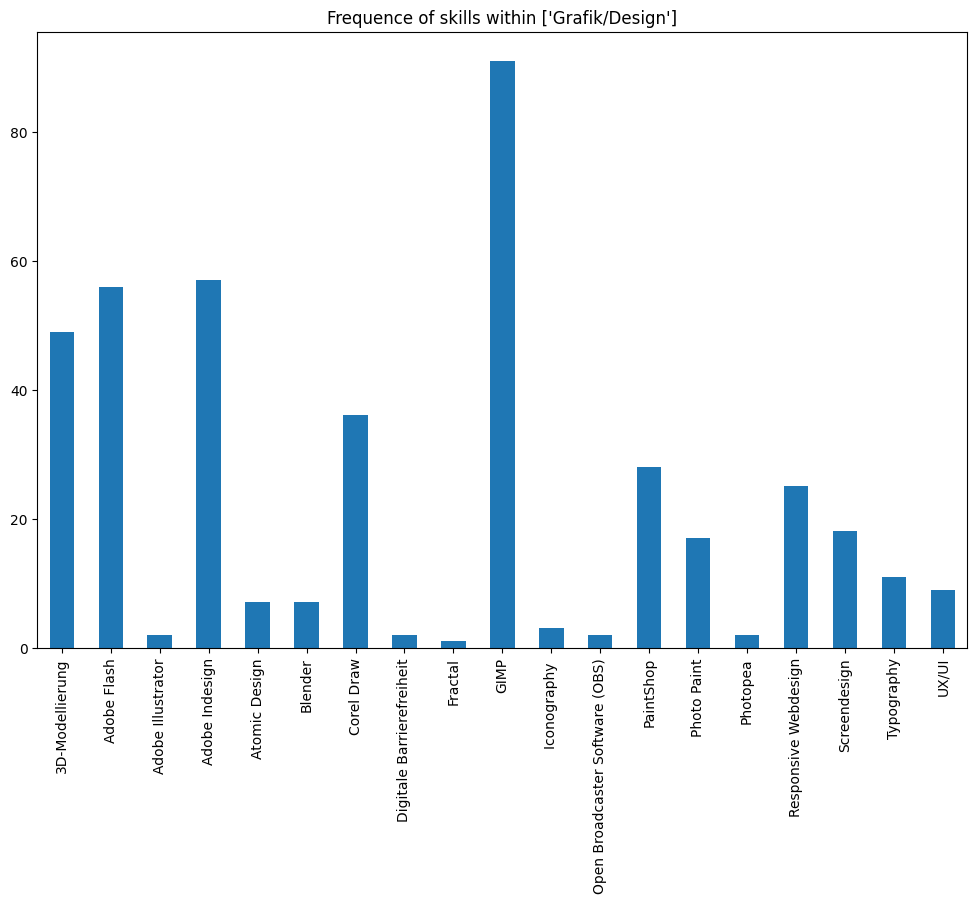

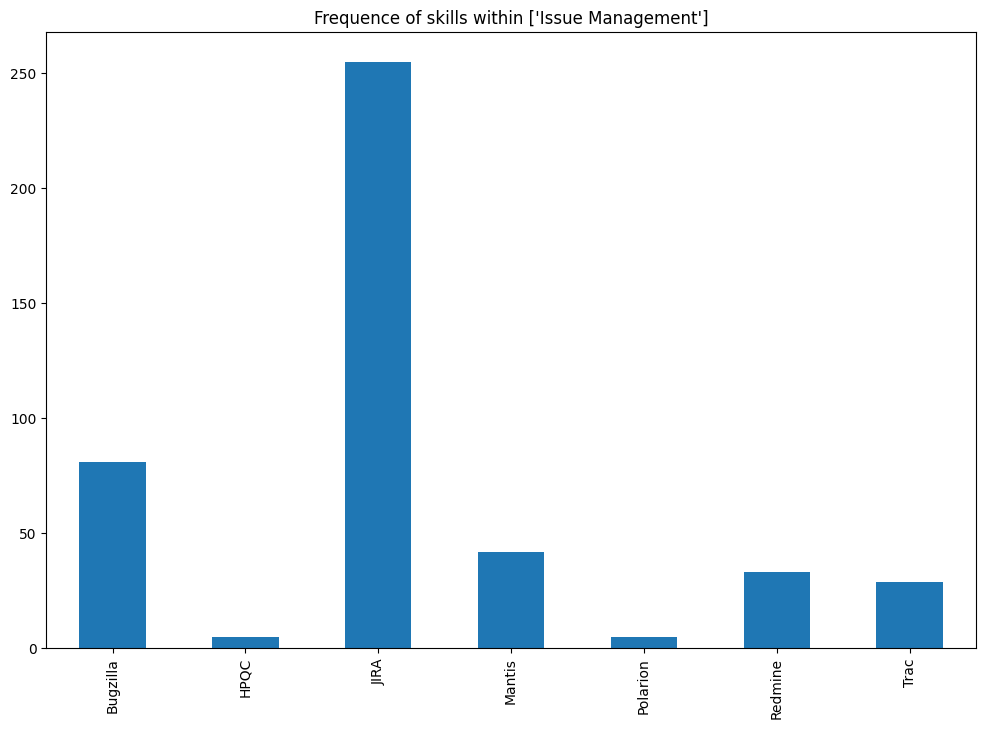

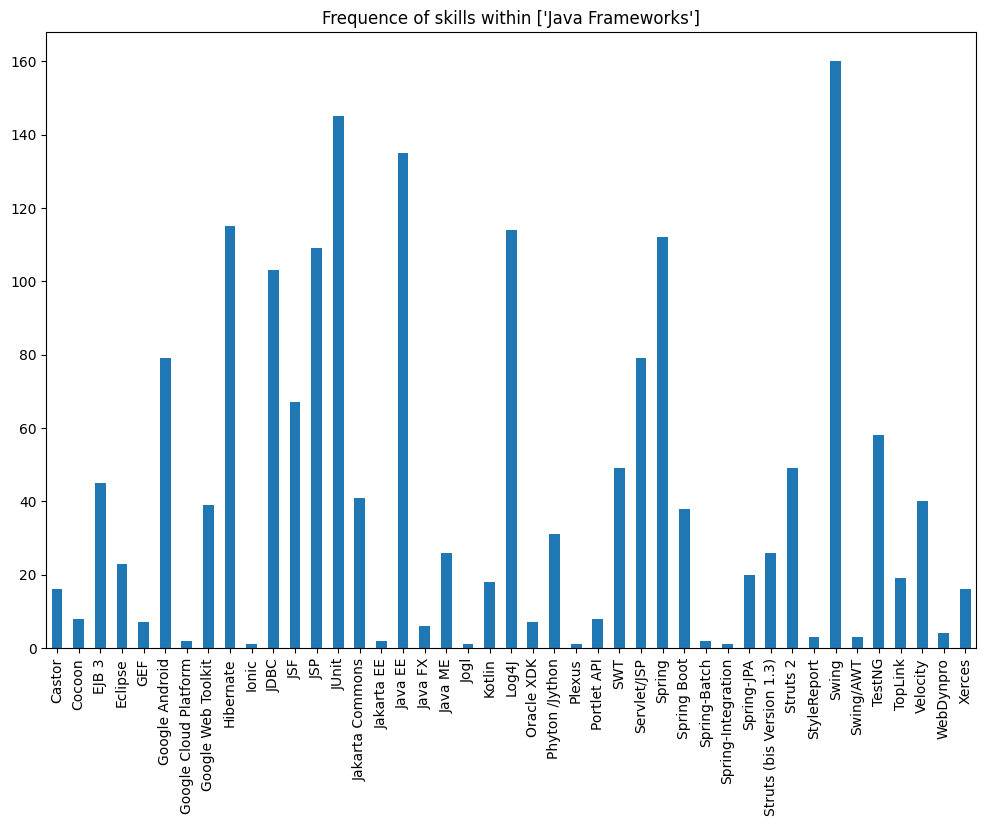

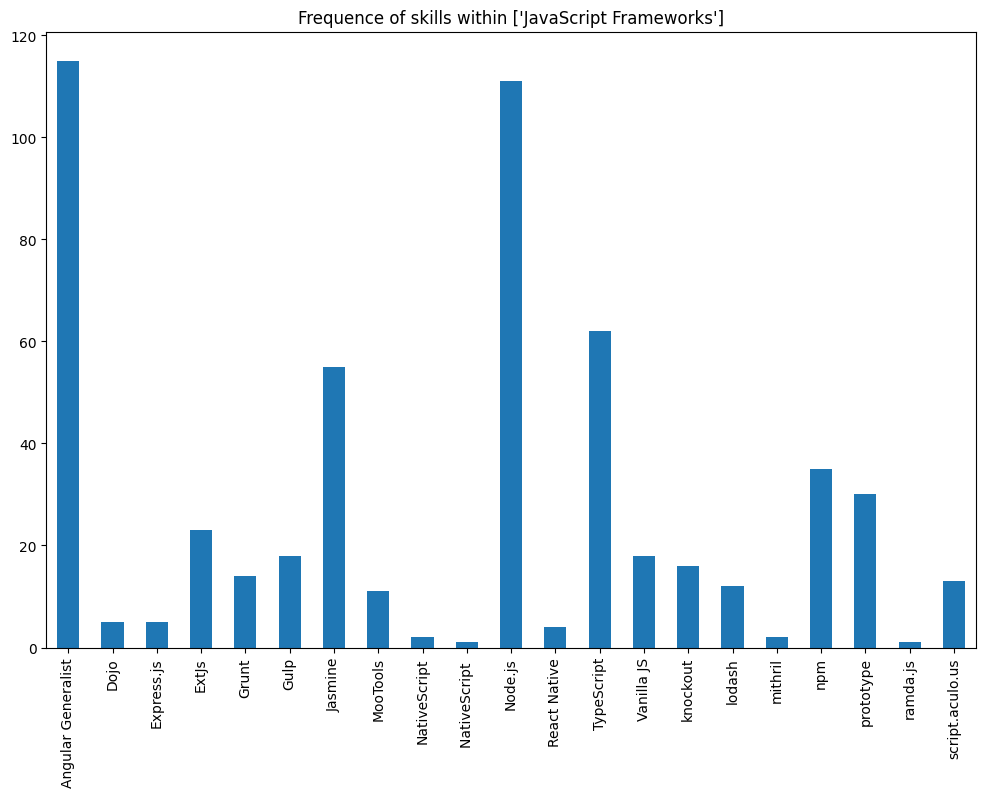

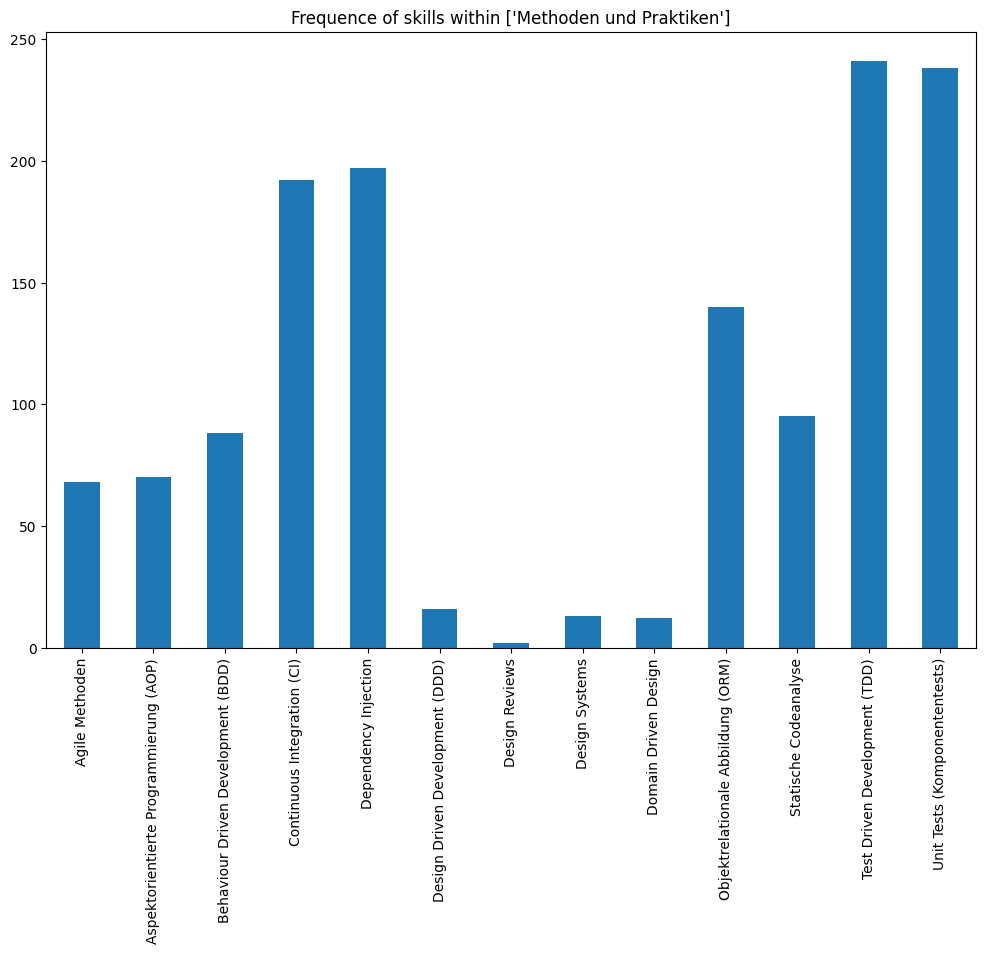

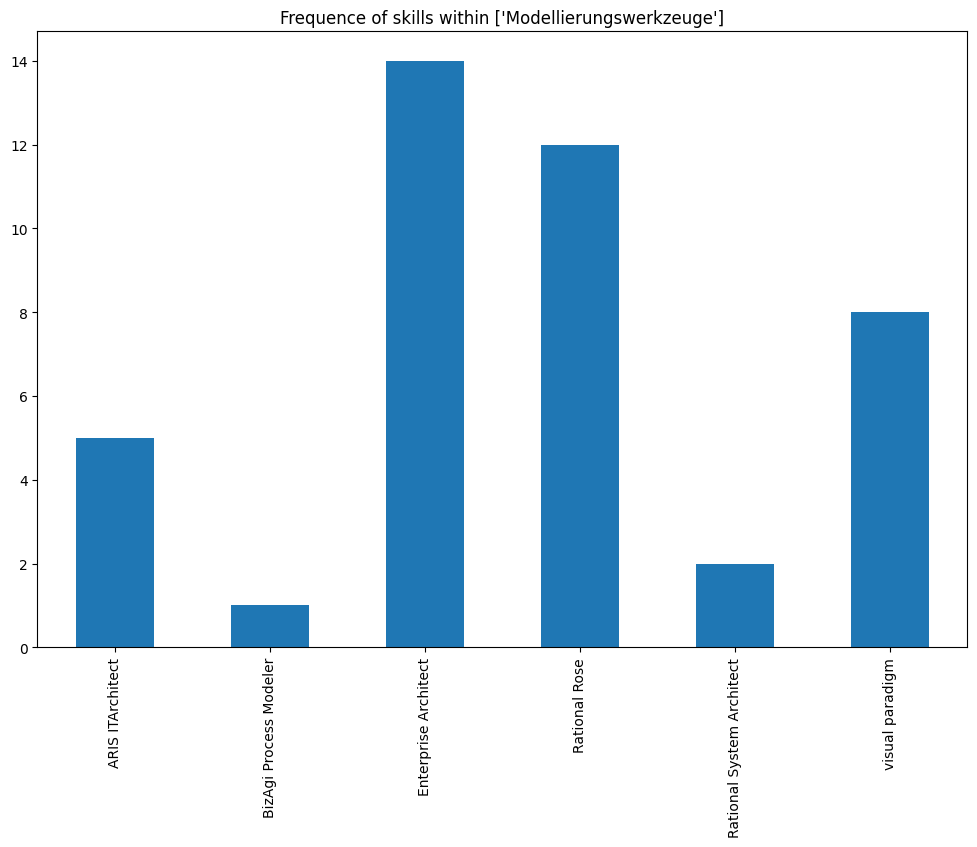

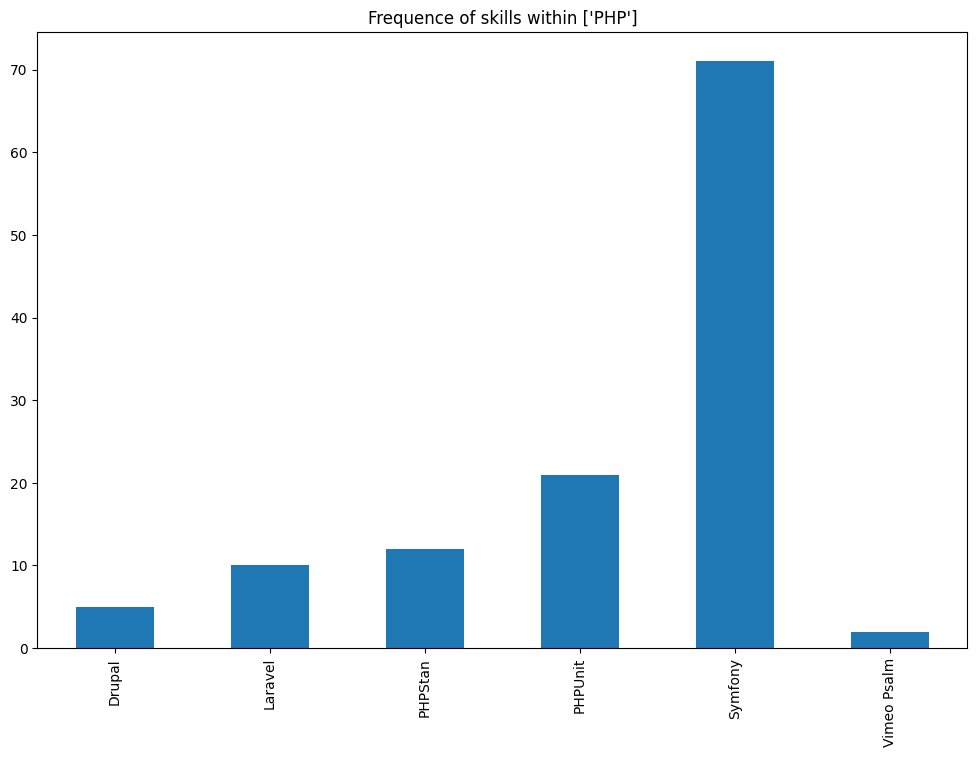

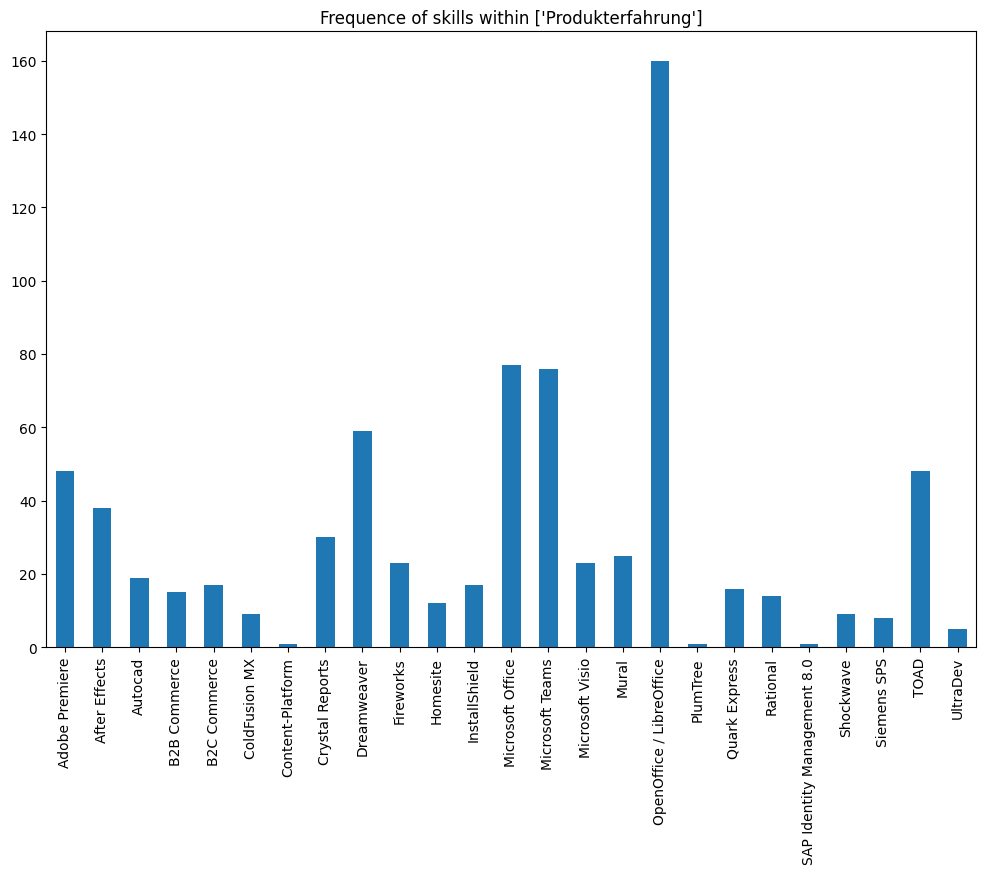

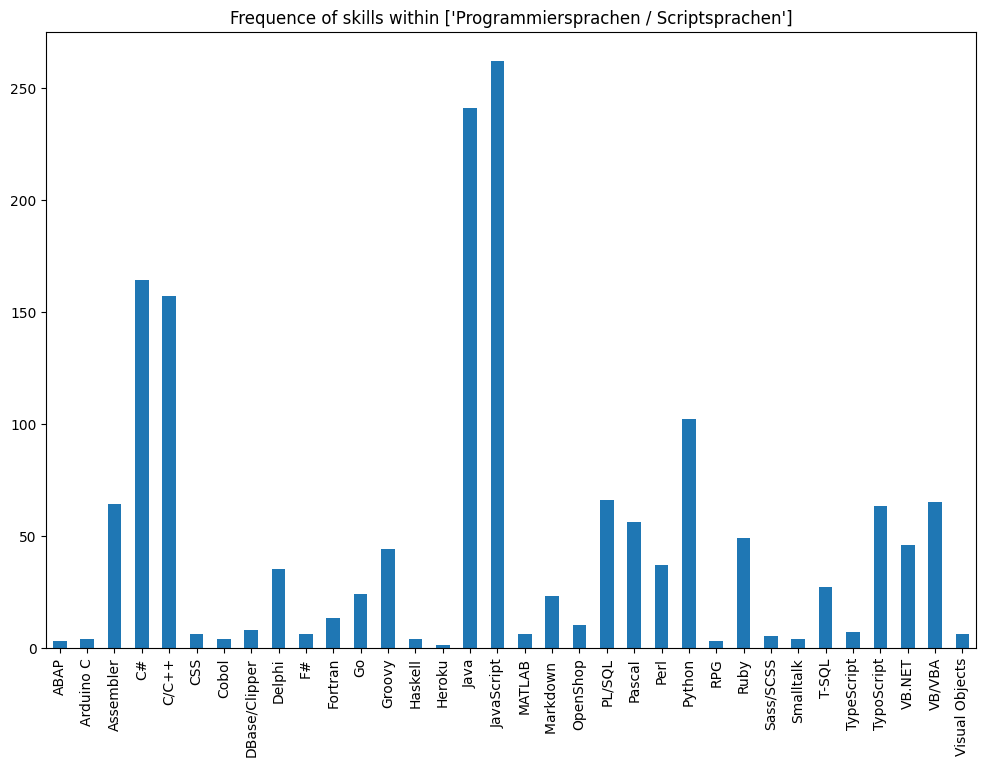

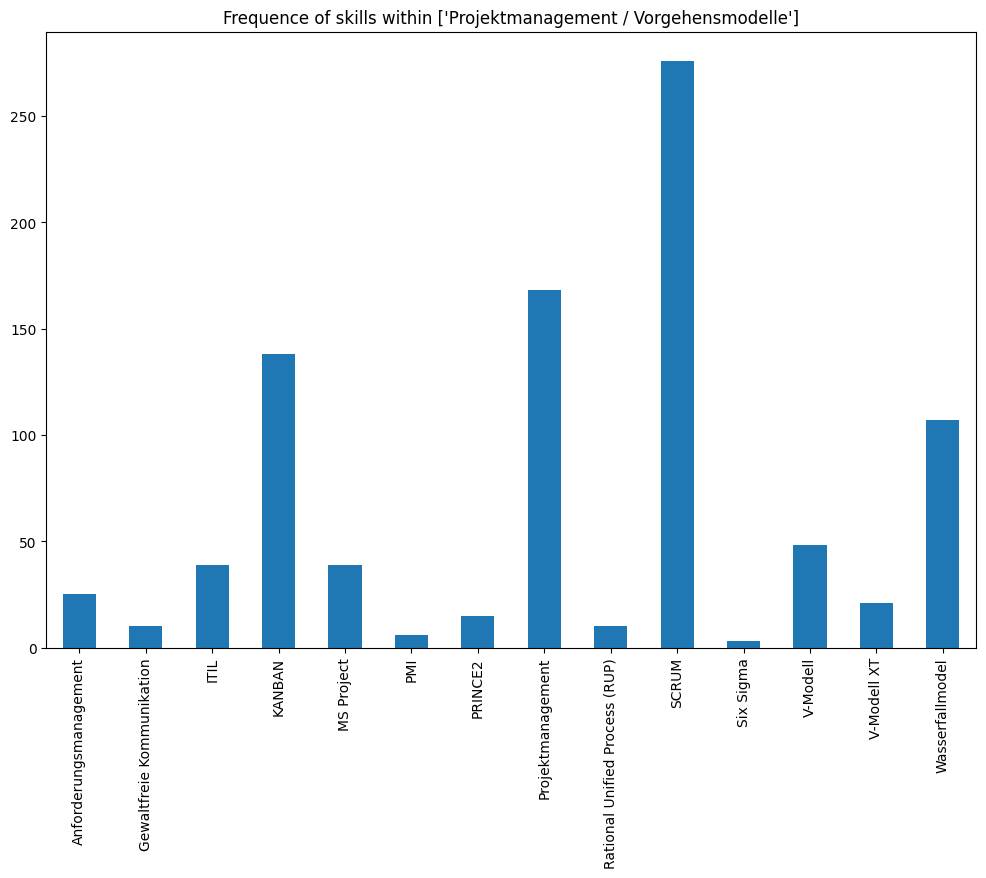

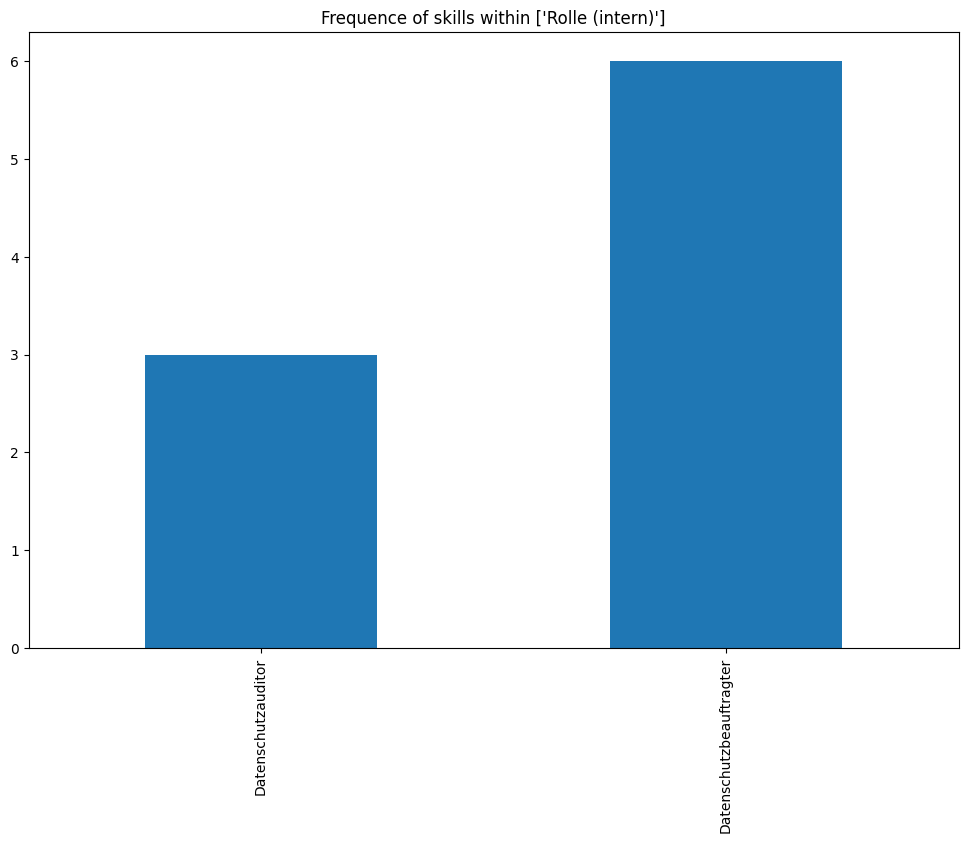

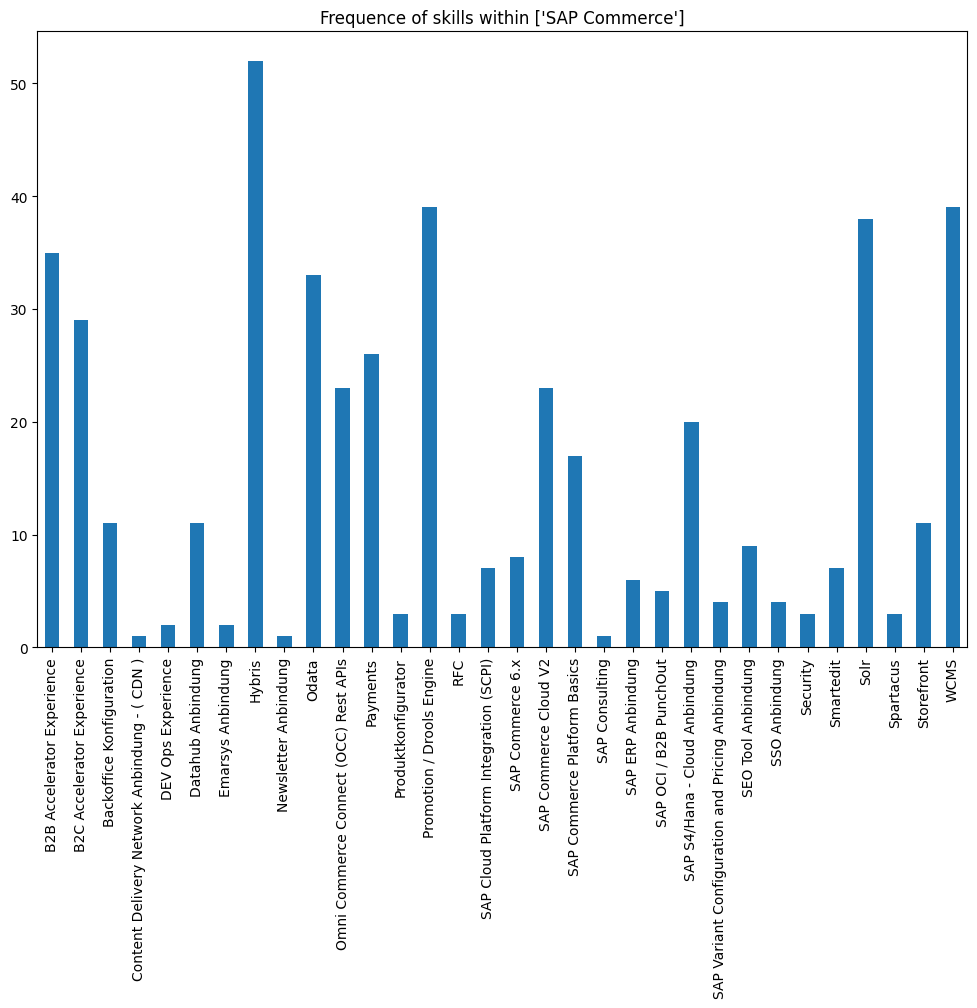

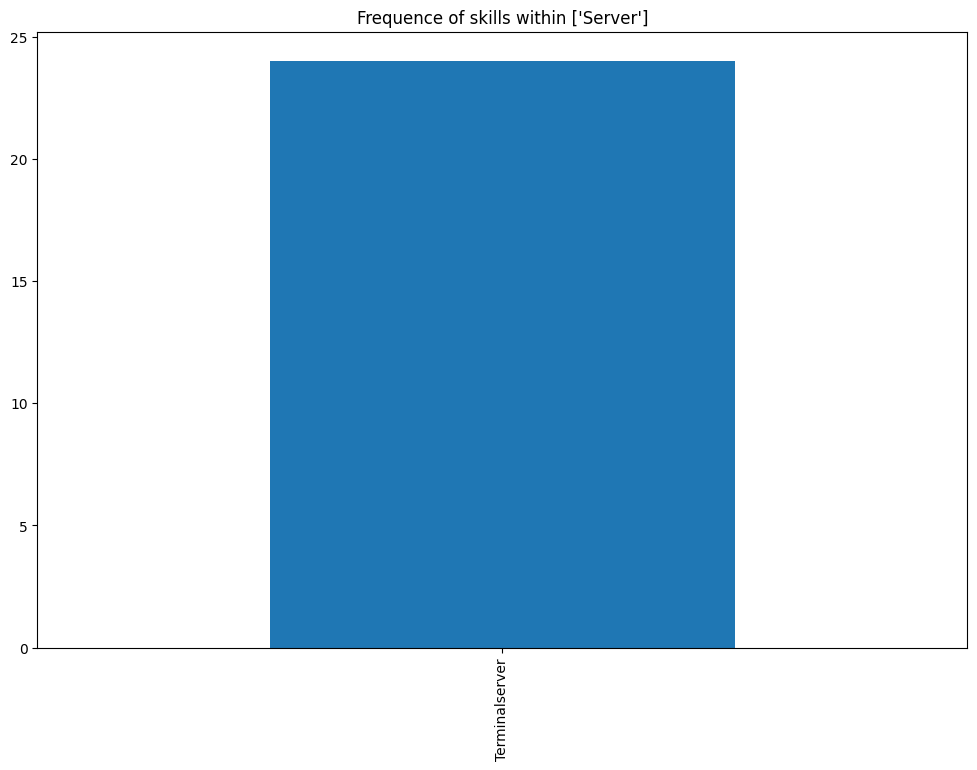

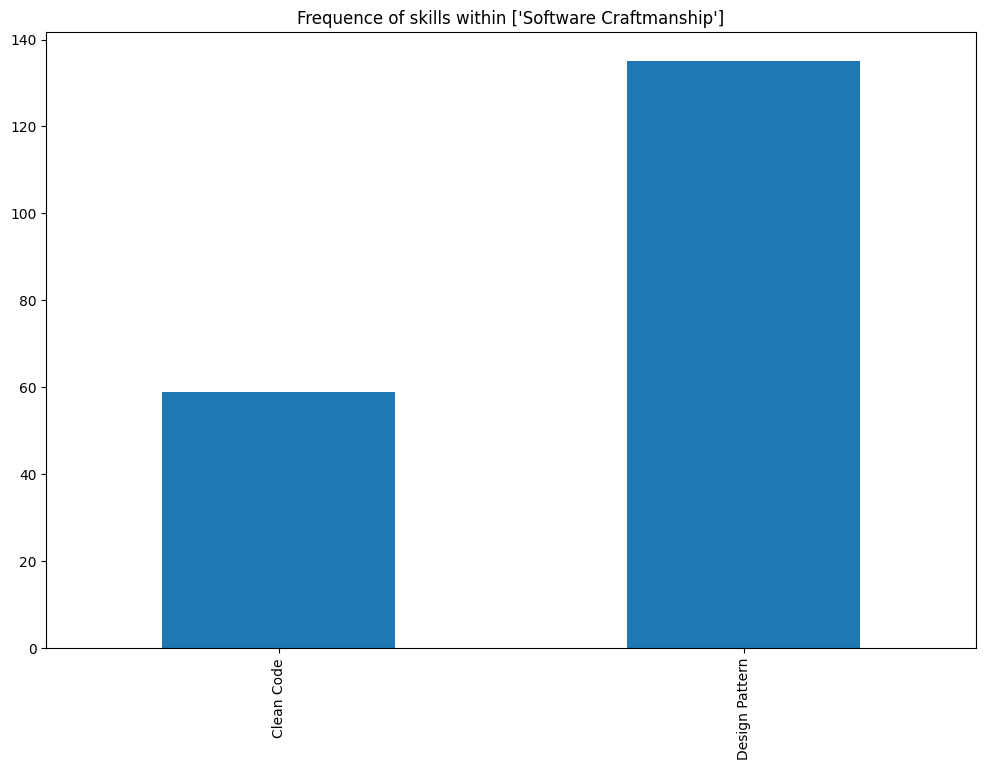

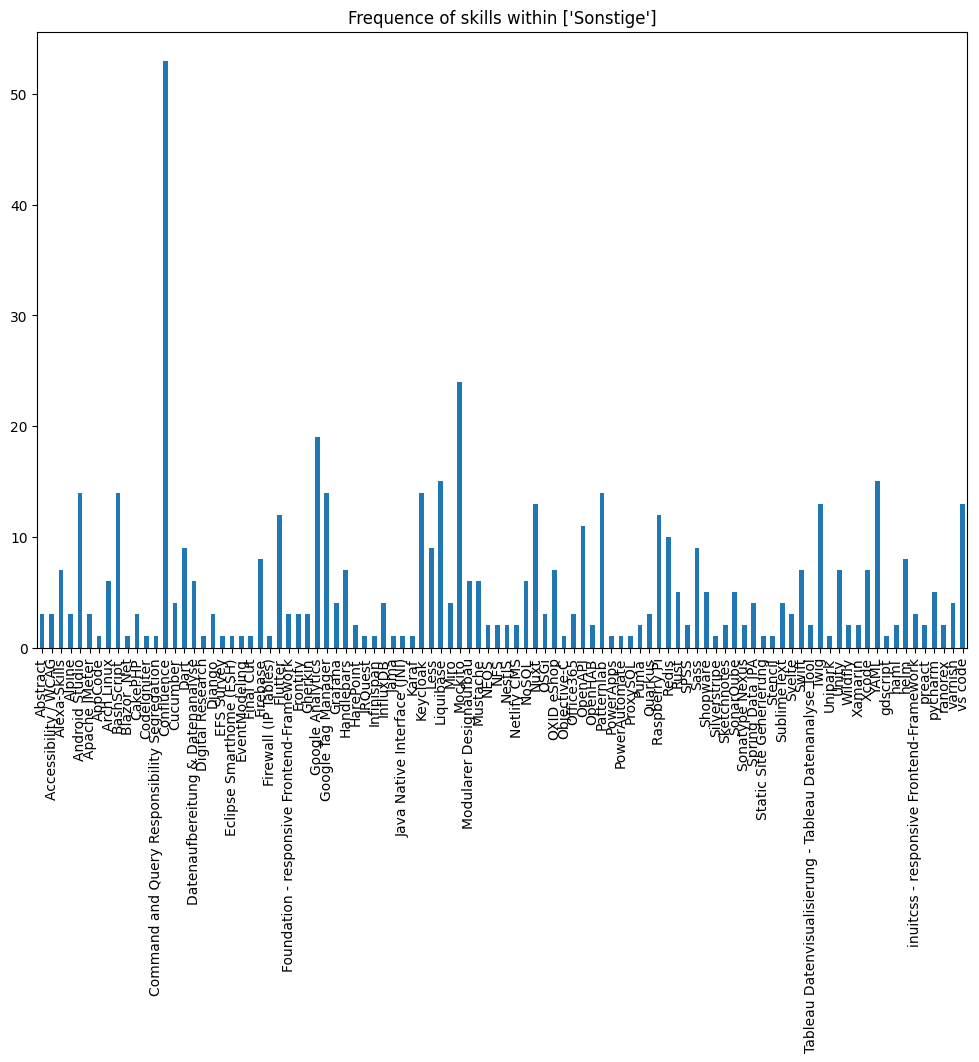

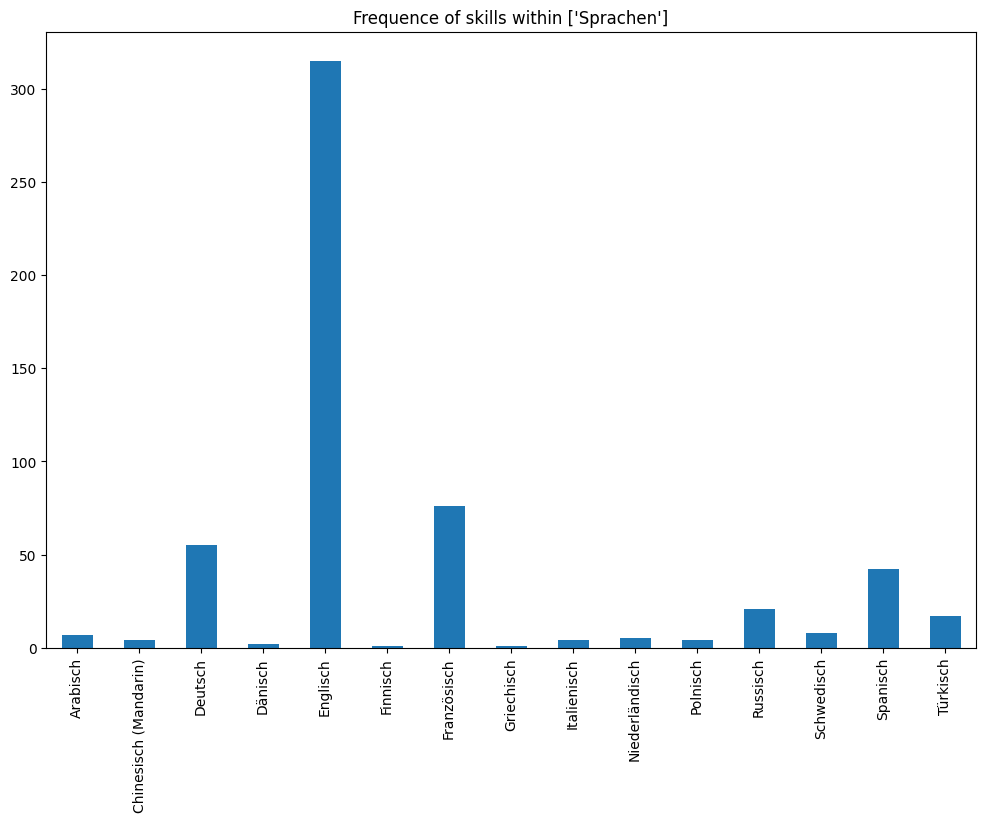

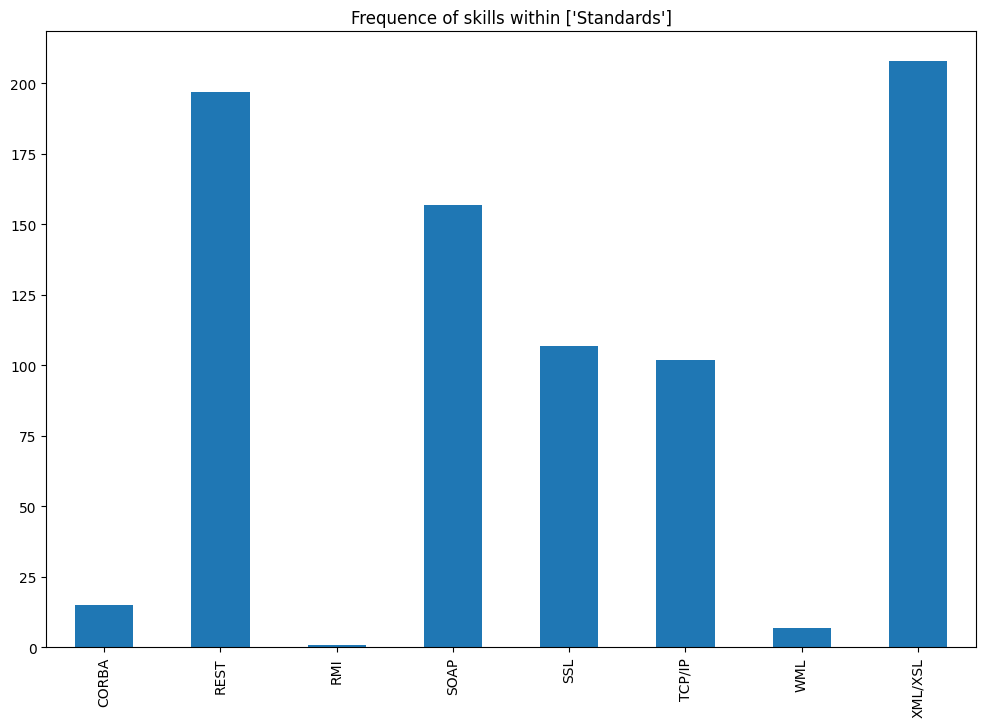

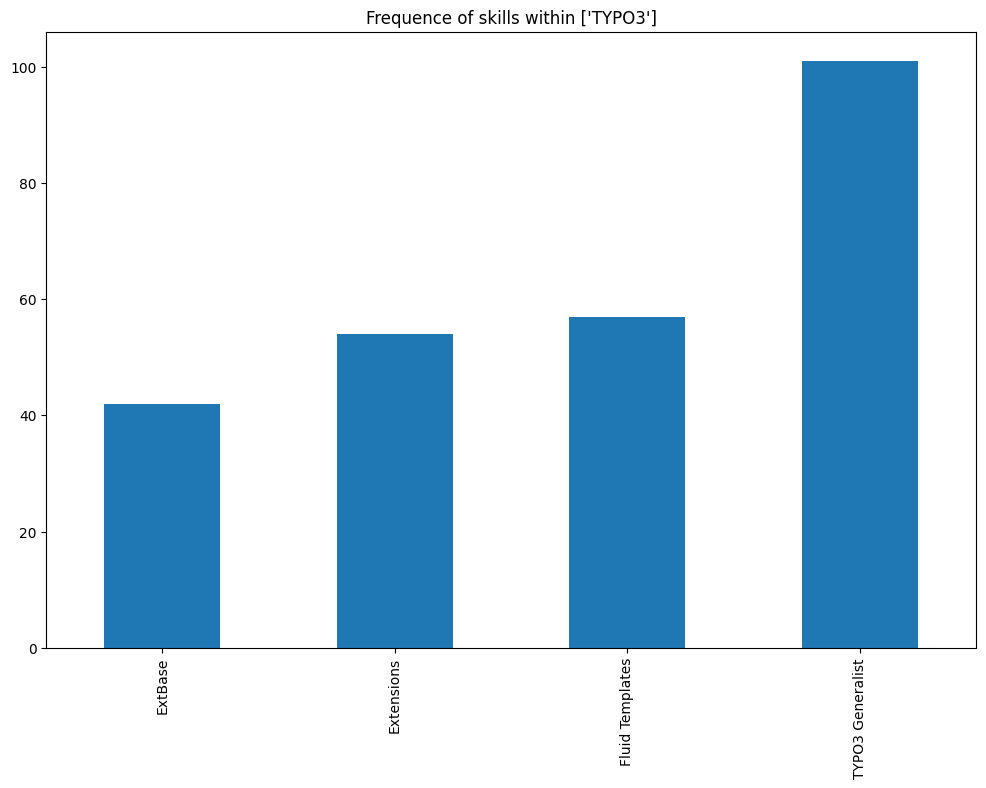

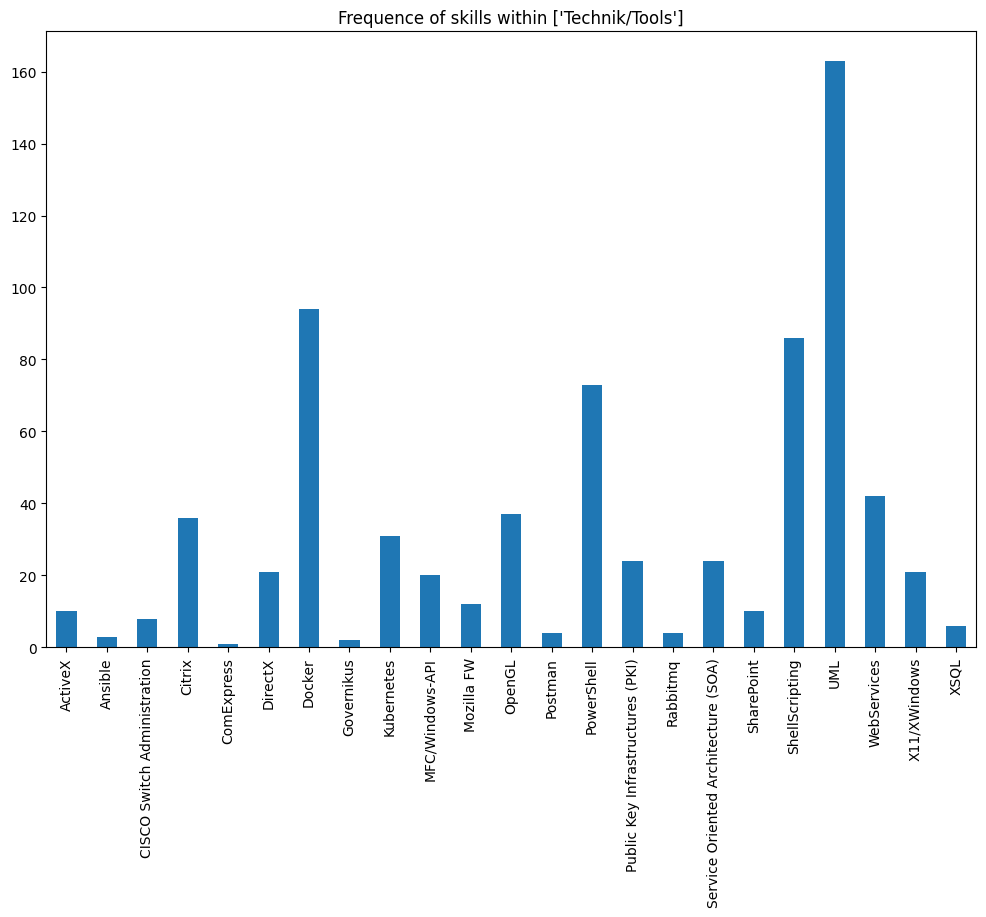

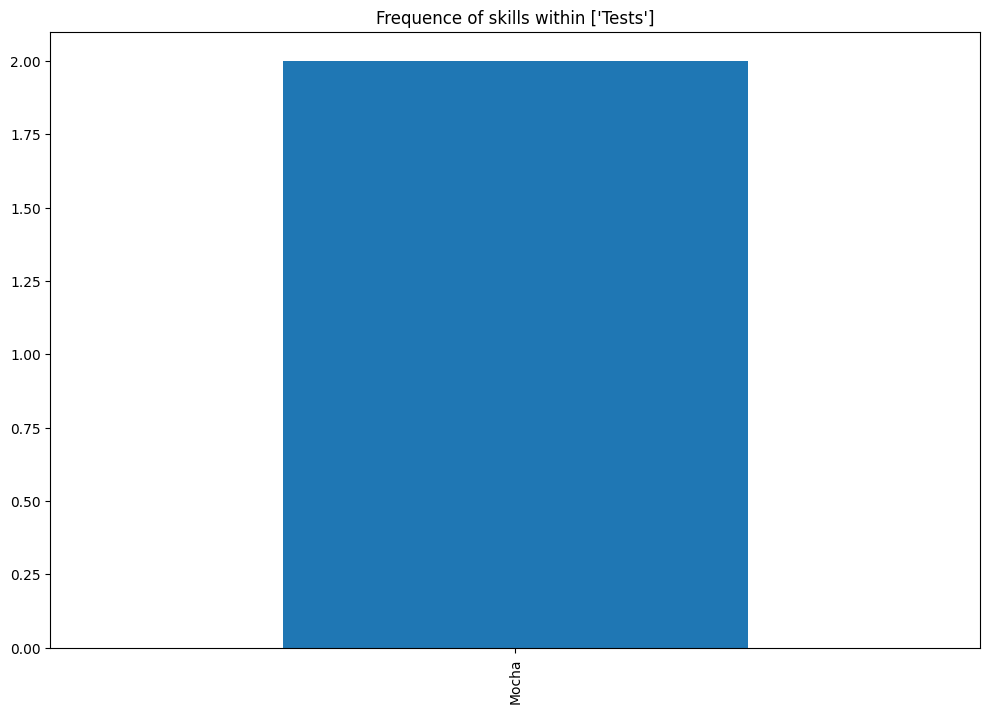

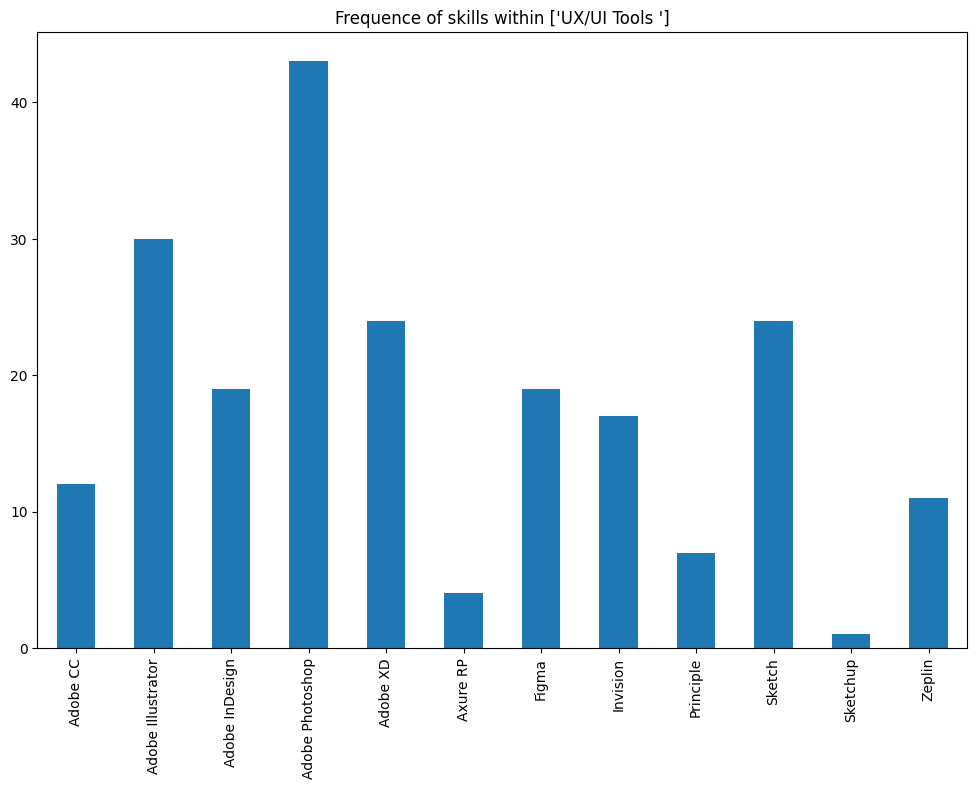

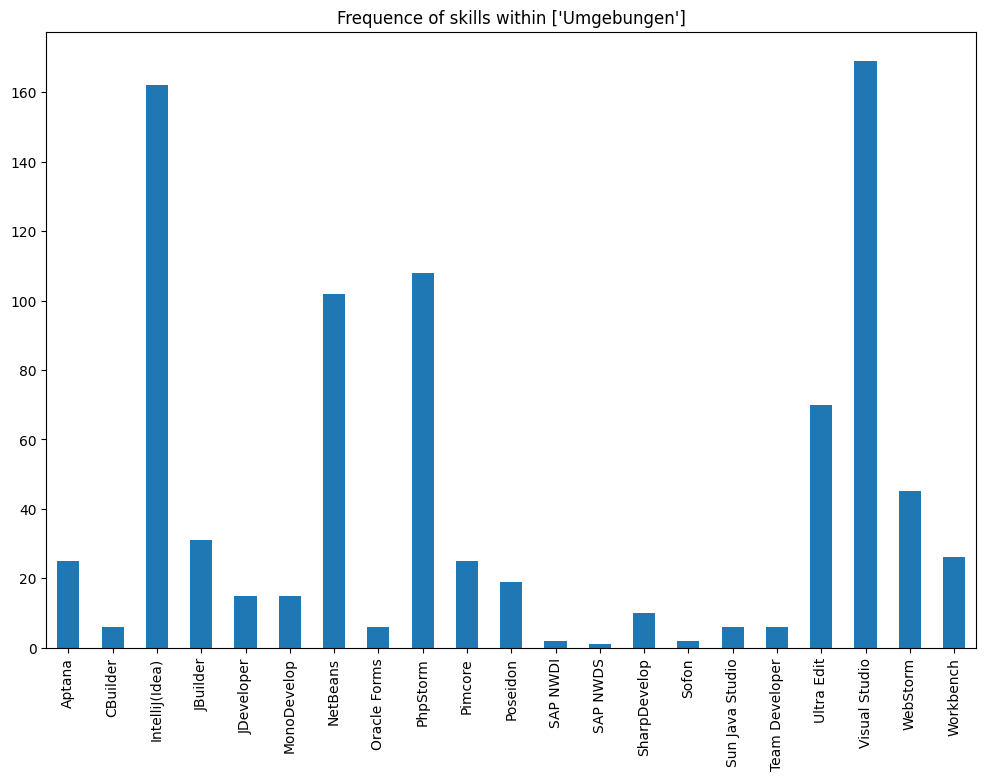

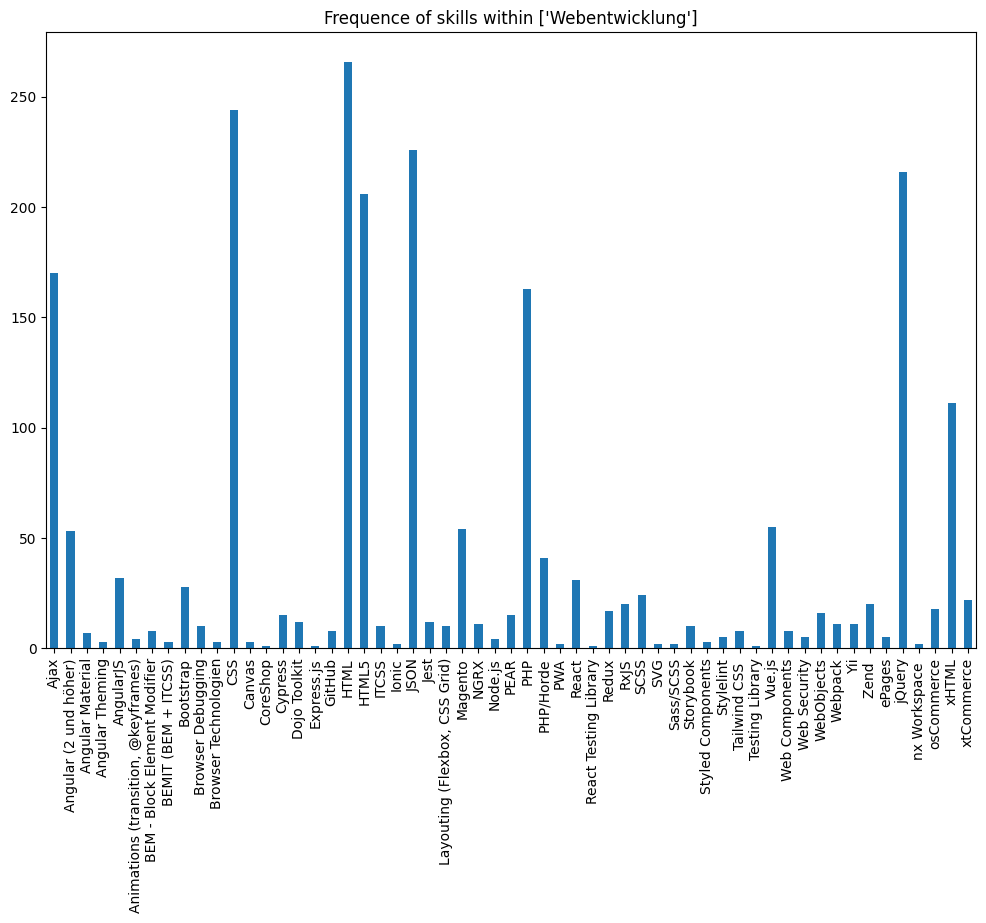

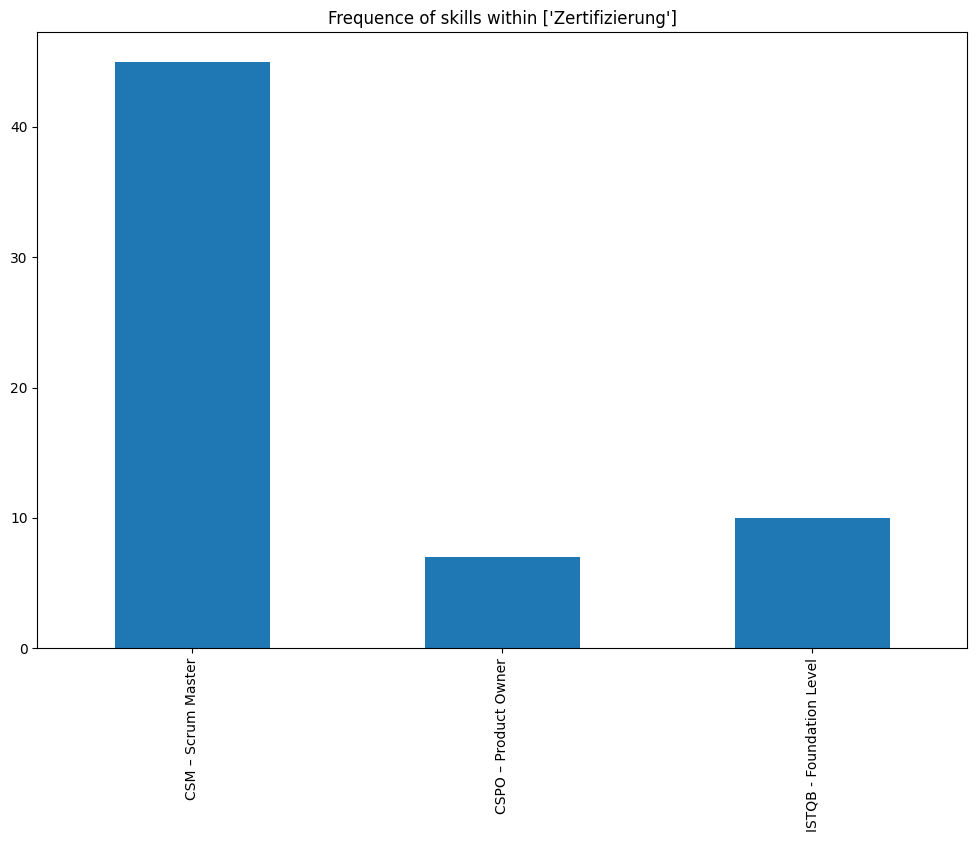

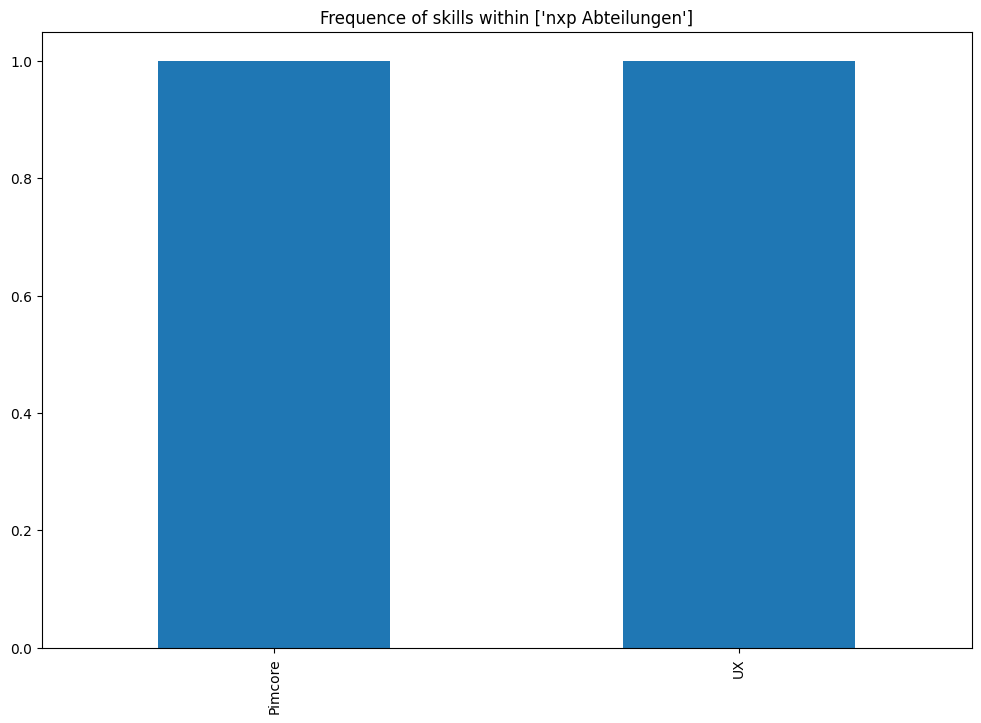

In [343]:
######
# Plots the distiribution within a category
#####
for i, content in enumerate(categories):

    cat = df_groupby_category_skills.loc[df_groupby_category_skills["category"] == content]

    # Plot the distribution within a category
    plt.figure(figsize=(12, 8))
    ax = cat.frequence.plot(kind="bar")
    ax.set_xticklabels(cat.skill)
    ax.set_title(f"Frequence of skills within {cat.category.unique()}")
    plt.show()

    break

   

In [ ]:
##Gruppieren bzw kategorisieren

In [300]:
df

,person,skill,category
0,12,Windows NT/2000/XP,Betriebssystem
1,12,MAC OS X,Betriebssystem
2,12,Windows 7,Betriebssystem
3,12,Windows 8,Betriebssystem
4,12,iOS,Betriebssystem
...,...,...,...
24581,1488,Deutsch,Sprachen
24582,1488,Spring-JPA,Java Frameworks
24583,1488,Maven,"CI/CD, Build- und Versionskontrollsysteme"
24584,1488,Subversion,"CI/CD, Build- und Versionskontrollsysteme"


In [ ]:
# Plot the figure.
plt.figure(figsize=(12, 8))
ax = category_count.number_of_skills_within.plot(kind="bar")
ax.set_title("Amount Frequency")
ax.set_xlabel("Amount ($)")
ax.set_ylabel("Frequency")
ax.set_xticklabels(x_labels)

rects = ax.patches

# Make some labels.
labels = [f"label{i}" for i in range(len(rects))]

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(
        rect.get_x() + rect.get_width() / 2, height + 5, label, ha="center", va="bottom"
    )

plt.show()

ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (24586,) and arg 1 with shape (43,).

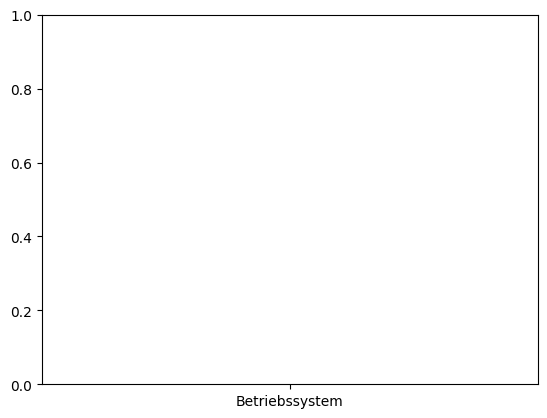

In [233]:
fig, ax = plt.subplots(figsize= [18,9])

bar_list = []
for i in range(0,len(category_count)):
    bar = ax.bar(x= category_count.index[i:i+1], height= data_products.tradevalue[i:i +1])
    bar_list.insert(i,bar)
    ax.bar_label(bar_list[i], labels = round(data_products.tradevalue[i:i +1]/1000000000,2))
ax.legend(data_products.cmddesce, loc =(0,1.05))
ax.set_title('Ukraine`s Top 10 export products in 2021 (aggregated on the world)')
ax.set_xlabel('product by code')
ax.set_ylabel('tradevalue (in US$)')
plt.show()




bar = ax.bar(x= category_count.pttitle, height= Top_10_countries_df.tradevalue)
ax.set_title('Ukraine`s Top 10 partner countries')
ax.set_xlabel('partner country')
ax.set_ylabel('tradevalue (in US$)')
ax.bar_label(container= bar, labels = round(Top_10_countries_df.tradevalue / 1000000000,2)) #note: the y axis says it's scale is in billion us dollar
plt.show()

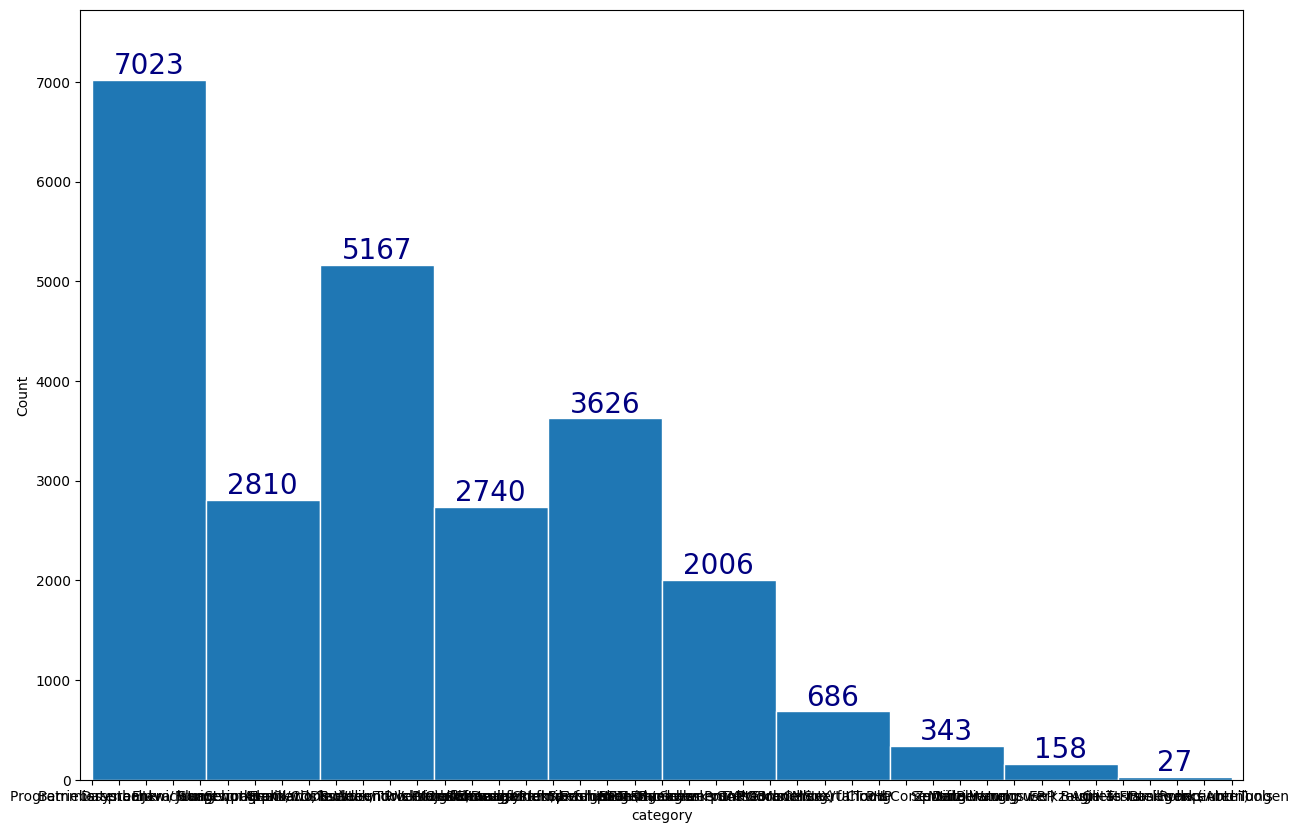

<BarContainer object of 10 artists>

In [228]:

# Creating histogram
fig, ax = plt.subplots(1, 1)
ax.hist(data = df,  x="category")
  
# Set title
ax.set_title("Title")
  
# adding labels
ax.set_xlabel('x-label')
ax.set_ylabel('y-label')
  
# Make some labels.
rects = ax.patches
labels = ["label%d" % i for i in range(len(rects))]
  
for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width() / 2, height+0.01, label,
            ha='center', va='bottom')

In [209]:
df.groupby(['category'])["category"].size()

category
.NET Frameworks und Tools                      790
Agilität                                         2
Applikationsserver                             612
BPM (Business Process Modelling)                36
Basics                                           8
Beratung                                       203
Betriebssystem                                1780
Branchenerfahrung                              242
C++ Frameworks und Tools                         6
CI/CD, Build- und Versionskontrollsysteme     1334
CMS                                            112
Cloud Computing                                 54
Data Warehouse / Business Intelligence          50
Datenbank                                     1468
Dienste                                        850
ERP                                             64
Einsatzfelder / Erfahrungen / Schwerpunkte    1618
Entwicklung                                    332
Grafik/Design                                  423
Issue Management      

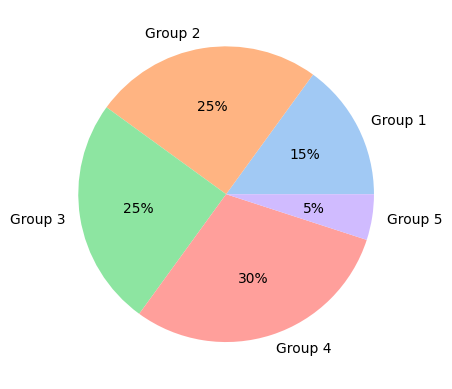

In [201]:

data = [15, 25, 25, 30, 5]
labels = ['Group 1', 'Group 2', 'Group 3', 'Group 4', 'Group 5']

#define Seaborn color palette to use
colors = sns.color_palette('pastel')[0:5]

#create pie chart
plt.pie(data, labels = labels, colors = colors, autopct='%.0f%%')
plt.show()

In [76]:
df_value_counts.index

Index(['Englisch', 'MySQL', 'SCRUM', 'GIT', 'HTML', 'JavaScript', 'JIRA',
       'CSS', 'Test Driven Development (TDD)', 'Java',
       ...
       'Objective-C', 'Qlik 12 Certified Business Analyst',
       'Content Delivery Network Anbindung - ( CDN )', 'Jogl', 'Sketchup',
       'Final Cut', 'Datadog', 'Pulumi', 'Qlik 12 Certified Data Architekt',
       'Spring-Integration'],
      dtype='object', length=737)

In [105]:
np.arange(0,750,50)

array([  0,  50, 100, 150, 200, 250, 300, 350, 400, 450, 500, 550, 600,
       650, 700])

In [98]:
np.arange?

Docstring:
arange([start,] stop[, step,], dtype=None, *, like=None)

Return evenly spaced values within a given interval.

``arange`` can be called with a varying number of positional arguments:

* ``arange(stop)``: Values are generated within the half-open interval
  ``[0, stop)`` (in other words, the interval including `start` but
  excluding `stop`).
* ``arange(start, stop)``: Values are generated within the half-open
  interval ``[start, stop)``.
* ``arange(start, stop, step)`` Values are generated within the half-open
  interval ``[start, stop)``, with spacing between values given by
  ``step``.

For integer arguments the function is roughly equivalent to the Python
built-in :py:class:`range`, but returns an ndarray rather than a ``range``
instance.

When using a non-integer step, such as 0.1, it is often better to use
`numpy.linspace`.

See the Warning sections below for more information.

Parameters
----------
start : integer or real, optional
    Start of interval.  The interva

# Notizen
* Evt Überlegen, ob wir die Kategorien wie Betriebssysteme usw. im ersten Lauf noch beibehalten sollten
